In [1]:
import os
import datetime

import numpy as np
from numba import cuda
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.model import unet_model
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from src.data_utils import plot_sample_batch, create_mask
from src.model_utils import (
    dice_coeff,
    dice_loss,
    dice_loss_old,
    dice_coeff_old,
    bce_dice_loss,
    tversky,
    tversky_loss,
    tversky_axis,
    tversky_loss_axis,
    focal_tversky_loss,
    dice_coeff_per_class,
    tversky_per_class,
    evaluate_per_class,
)


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-10-21 18:03:20.567342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-10-21 18:03:20.567503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-21 18:03:20.715870: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-21 18:03:24.269770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-10-21 18:03:24.270165: W tensorflow

## Load Test Set

In [2]:
IMG_SHAPE = (256, 1600)
BATCH_SIZE = 8
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"
# LOSSES = {
#     "dice_loss": dice_loss,
#     "dice_loss_old": dice_loss_old,
#     "bce_dice_loss": bce_dice_loss,
#     "tversky_loss": tversky_loss,
#     "tversky_loss_axis": tversky_loss_axis,
#     "focal_tversky_loss": focal_tversky_loss,
# }
# METRICS = {
#     "dice_coeff": dice_coeff,
#     "dice_coeff_old": dice_coeff_old,
#     "tversky": tversky,
#     "tversky_axis": tversky_axis,
# }
LOSSES = {
    "tversky_loss": tversky_loss,
    "tversky_loss_axis": tversky_loss_axis,
}
METRICS = {
    "tversky": tversky,
    "tversky_axis": tversky_axis,
}

# instantiate dataset and pipelne
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
)

# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.1)

# small sample
_, train_imgs = train_test_split(
    sd.imgid_to_classid_mapping[train_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[train_imgs],
)
_, test_imgs = train_test_split(
    sd.imgid_to_classid_mapping[test_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[test_imgs],
)
train_imgs = list(train_imgs.index)
test_imgs = list(test_imgs.index)

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,
        "cache": False,
        "shuffle_buffer_size": False,
        "batch_size": BATCH_SIZE,
        "prefetch": False,
    },
)
train_dataset = sdp(X_train, y_train, is_train=True)
test_dataset = sdp(X_test, y_test, is_train=False)

{-2: 1.1604, -1: 0.4045, 1: 0.7517, 2: 2.2761, 3: 0.4069, 4: 1.0004}


2022-10-21 18:04:11.916506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-10-21 18:04:11.916684: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-21 18:04:11.916800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9fafyhussi33dm0m): /proc/driver/nvidia/version does not exist


AUGMENTING!!
Batching
Batching


## Inference

In [7]:
# MODEL_PATH = "../logs/unet-epochs_15-lr_0.005-channels_512-loss_dice_loss-20221012-175613/best_model.h5"
MODEL_PATH = "../logs/unet-epochs_100-lr_0.01-channels_512-loss_tversky_loss-20221014-135310/best_model.h5"
# MODEL_PATH = "../logs/unet-epochs_50-lr_0.01-channels_512-loss_dice_loss_old-sw_True-20221018-210244/best_model.h5"
MODEL_PATH = (
    "../logs/WITH-SAMPLEWEIGHTS-150_TVERSKY_LOSS_AXIS-20221019-164542/best_model.h5"
)

# unet_model = tf.keras.models.load_model(
#     MODEL_PATH,
# )

unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

In [8]:
sample = list(test_dataset.take(1).as_numpy_iterator())

x = sample[0][0]
y_true = sample[0][1]
y_pred = unet_model.predict(x)

x.shape, y_true.shape, y_pred.shape

2022-10-19 17:52:56.851775: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2022-10-19 17:52:59.877667: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-19 17:52:59.885332: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-19 17:52:59.885464: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-19 17:52:59.888566: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-19 17:52:59.888821: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 33s 33s/step


((8, 256, 1600, 3), (8, 256, 1600, 5), (8, 256, 1600, 5))

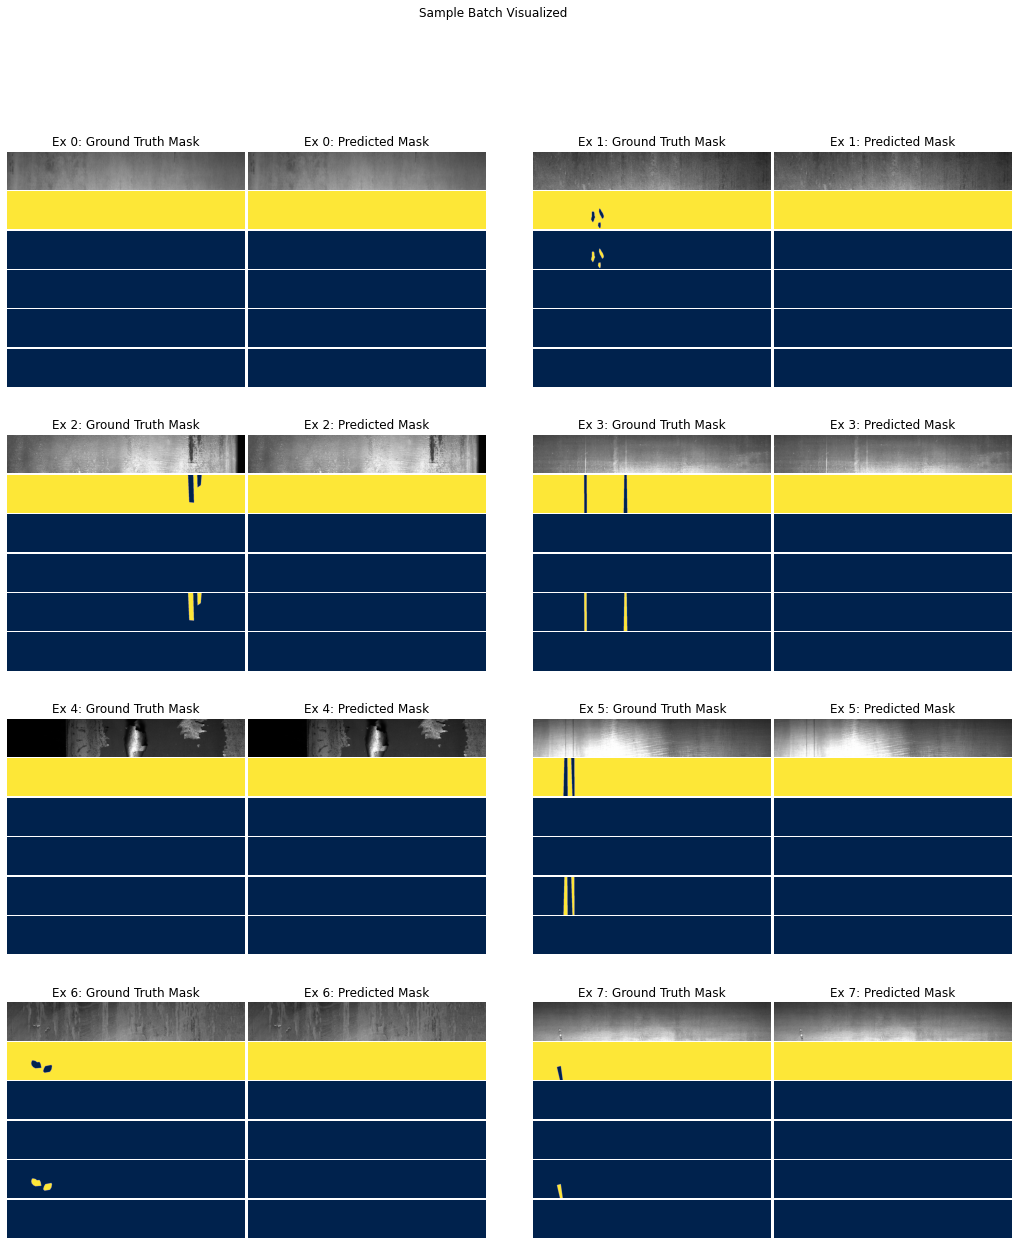

In [9]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

## Plot predictions from multiple batches

#### epochs_100-lr_0.01-channels_512-loss_tversky_loss-20221014-135310

- Tversky Loss, No Sample Weighting
- Learns only Class 3 defects

In [14]:
MODEL_PATH = "../logs/unet-epochs_100-lr_0.01-channels_512-loss_tversky_loss-20221014-135310/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

1/1 [==============================] - 0s 93ms/step


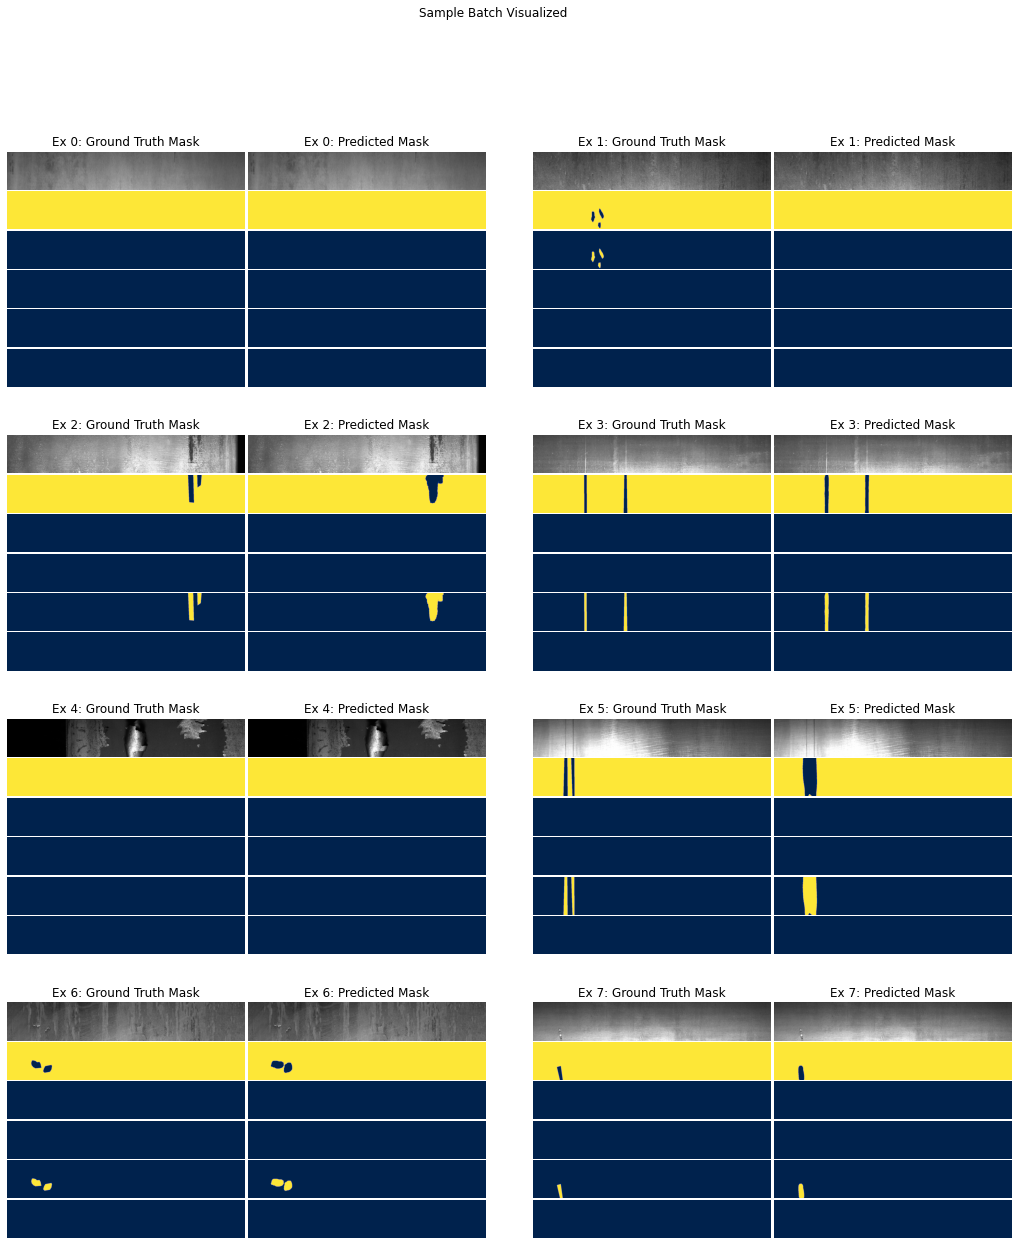

1/1 [==============================] - 0s 77ms/step


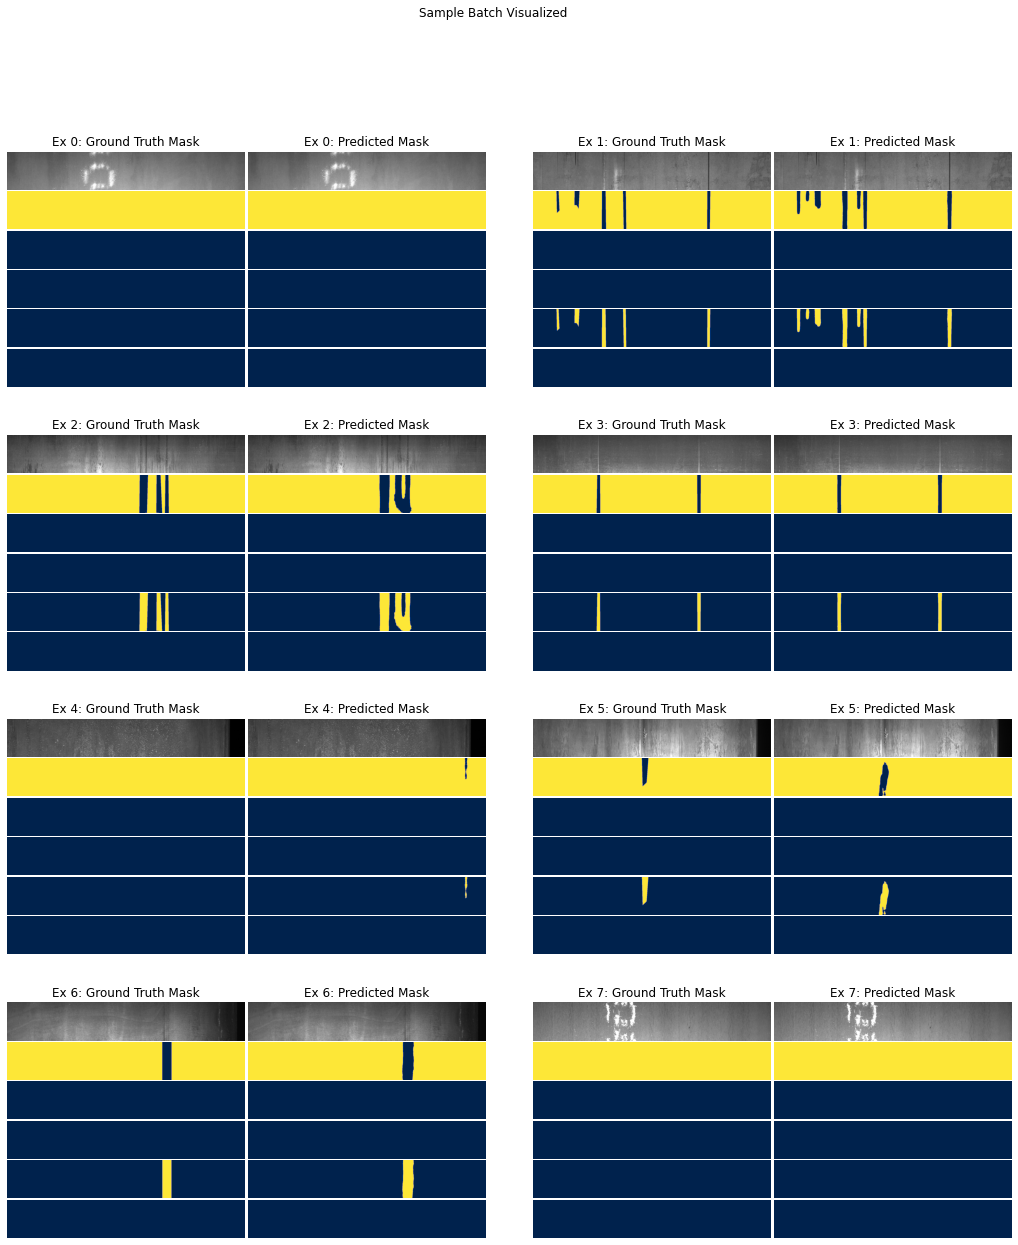

1/1 [==============================] - 0s 54ms/step


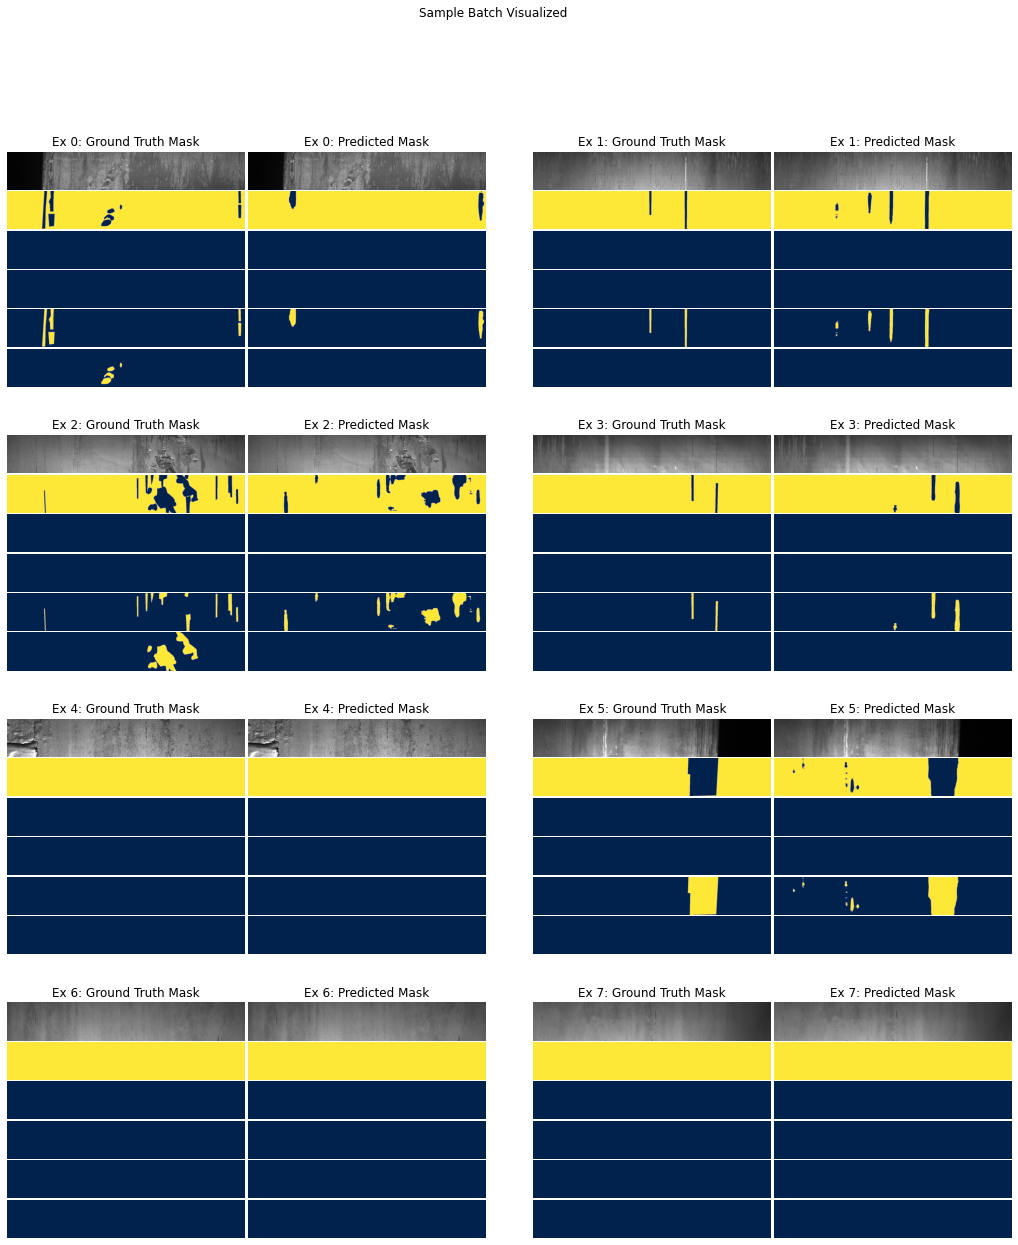

1/1 [==============================] - 0s 59ms/step


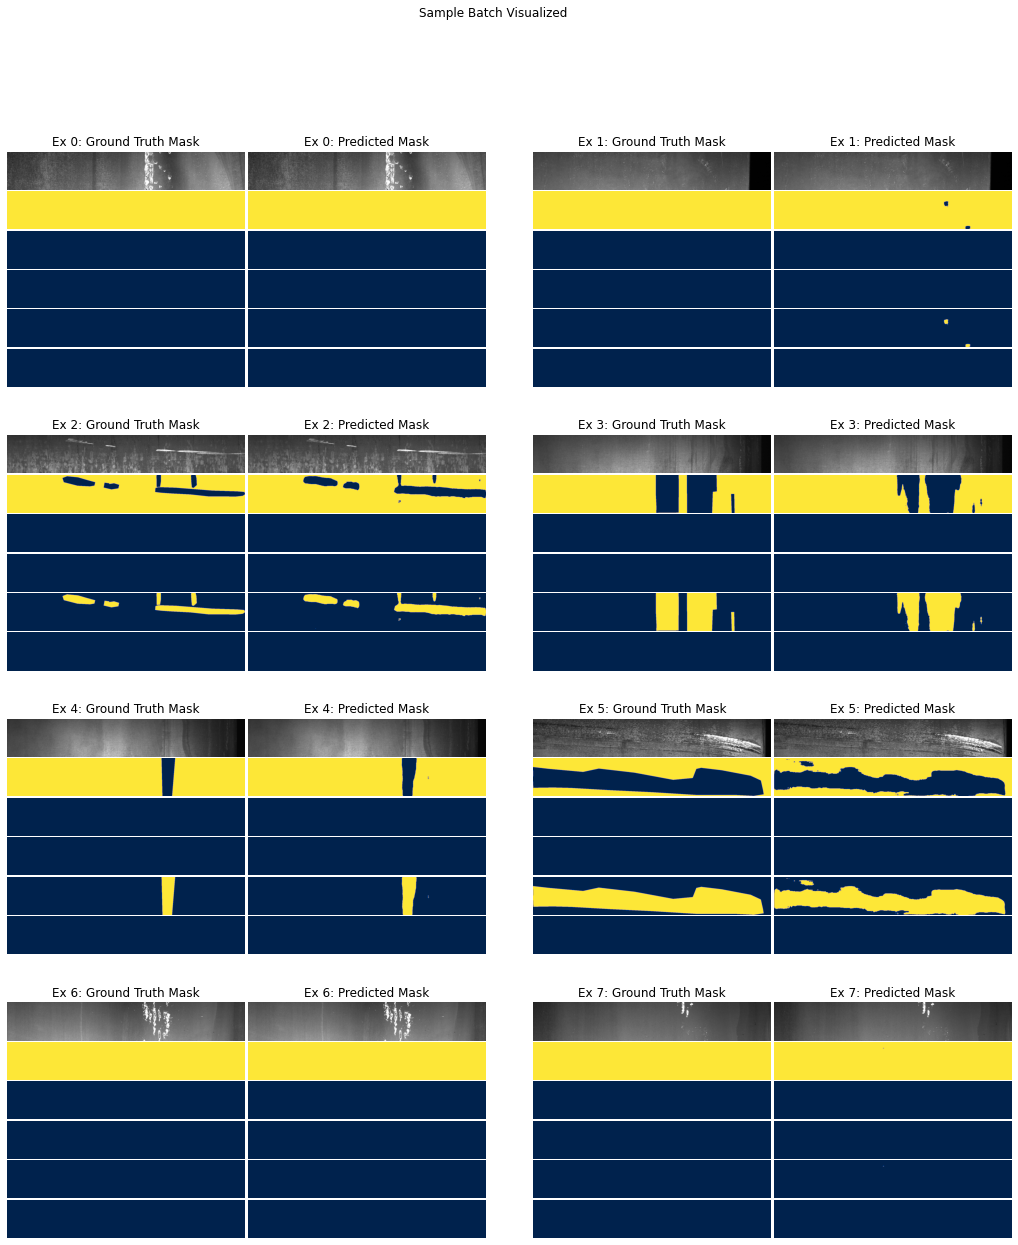

In [11]:
sample = list(test_dataset.take(4).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

    plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [15]:
# class_scores = evaluate_per_class_dice(test_dataset, unet_model)
class_scores = evaluate_per_class(test_dataset, unet_model, tversky_per_class)

  0%|          | 0/158 [00:00<?, ?it/s]

1/1 [==============================] - 0s 476ms/step


  1%|          | 1/158 [00:01<02:59,  1.14s/it]

1/1 [==============================] - 0s 187ms/step


  1%|▏         | 2/158 [00:01<02:04,  1.25it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 3/158 [00:02<01:46,  1.46it/s]

1/1 [==============================] - 0s 180ms/step


  3%|▎         | 4/158 [00:02<01:38,  1.56it/s]

1/1 [==============================] - 0s 169ms/step


  3%|▎         | 5/158 [00:03<01:30,  1.69it/s]

1/1 [==============================] - 0s 183ms/step


  4%|▍         | 6/158 [00:03<01:27,  1.73it/s]

1/1 [==============================] - 0s 172ms/step


  4%|▍         | 7/158 [00:04<01:25,  1.76it/s]

1/1 [==============================] - 0s 74ms/step


  5%|▌         | 8/158 [00:04<01:21,  1.85it/s]

1/1 [==============================] - 0s 171ms/step


  6%|▌         | 9/158 [00:05<01:18,  1.90it/s]

1/1 [==============================] - 0s 170ms/step


  6%|▋         | 10/158 [00:05<01:15,  1.95it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 11/158 [00:06<01:13,  2.00it/s]

1/1 [==============================] - 0s 88ms/step


  8%|▊         | 12/158 [00:06<01:11,  2.03it/s]

1/1 [==============================] - 0s 79ms/step


  8%|▊         | 13/158 [00:07<01:12,  2.00it/s]

1/1 [==============================] - 0s 79ms/step


  9%|▉         | 14/158 [00:07<01:12,  2.00it/s]

1/1 [==============================] - 0s 103ms/step


  9%|▉         | 15/158 [00:08<01:13,  1.95it/s]

1/1 [==============================] - 0s 185ms/step


 10%|█         | 16/158 [00:08<01:12,  1.96it/s]

1/1 [==============================] - 0s 170ms/step


 11%|█         | 17/158 [00:09<01:13,  1.91it/s]

1/1 [==============================] - 0s 87ms/step


 11%|█▏        | 18/158 [00:09<01:11,  1.96it/s]

1/1 [==============================] - 0s 177ms/step


 12%|█▏        | 19/158 [00:10<01:10,  1.98it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█▎        | 20/158 [00:10<01:09,  1.99it/s]

1/1 [==============================] - 0s 174ms/step


 13%|█▎        | 21/158 [00:11<01:09,  1.98it/s]

1/1 [==============================] - 0s 172ms/step


 14%|█▍        | 22/158 [00:11<01:10,  1.93it/s]

1/1 [==============================] - 0s 163ms/step


 15%|█▍        | 23/158 [00:12<01:08,  1.97it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█▌        | 24/158 [00:13<01:09,  1.91it/s]

1/1 [==============================] - 0s 178ms/step


 16%|█▌        | 25/158 [00:13<01:08,  1.93it/s]

1/1 [==============================] - 0s 174ms/step


 16%|█▋        | 26/158 [00:14<01:07,  1.95it/s]

1/1 [==============================] - 0s 172ms/step


 17%|█▋        | 27/158 [00:14<01:07,  1.95it/s]

1/1 [==============================] - 0s 177ms/step


 18%|█▊        | 28/158 [00:15<01:06,  1.97it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 29/158 [00:15<01:04,  2.00it/s]

1/1 [==============================] - 0s 80ms/step


 19%|█▉        | 30/158 [00:16<01:03,  2.01it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 31/158 [00:16<01:02,  2.03it/s]

1/1 [==============================] - 0s 82ms/step


 20%|██        | 32/158 [00:17<01:04,  1.94it/s]

1/1 [==============================] - 0s 86ms/step


 21%|██        | 33/158 [00:17<01:05,  1.91it/s]

1/1 [==============================] - 0s 80ms/step


 22%|██▏       | 34/158 [00:18<01:03,  1.95it/s]

1/1 [==============================] - 0s 82ms/step


 22%|██▏       | 35/158 [00:18<01:03,  1.92it/s]

1/1 [==============================] - 0s 178ms/step


 23%|██▎       | 36/158 [00:19<01:02,  1.96it/s]

1/1 [==============================] - 0s 98ms/step


 23%|██▎       | 37/158 [00:19<01:02,  1.95it/s]

1/1 [==============================] - 0s 175ms/step


 24%|██▍       | 38/158 [00:20<01:01,  1.96it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▍       | 39/158 [00:20<01:00,  1.97it/s]

1/1 [==============================] - 0s 76ms/step


 25%|██▌       | 40/158 [00:21<00:58,  2.01it/s]

1/1 [==============================] - 0s 76ms/step


 26%|██▌       | 41/158 [00:21<00:58,  2.00it/s]

1/1 [==============================] - 0s 185ms/step


 27%|██▋       | 42/158 [00:22<00:59,  1.94it/s]

1/1 [==============================] - 0s 81ms/step


 27%|██▋       | 43/158 [00:22<01:00,  1.90it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 44/158 [00:23<01:00,  1.88it/s]

1/1 [==============================] - 0s 175ms/step


 28%|██▊       | 45/158 [00:23<01:00,  1.86it/s]

1/1 [==============================] - 0s 177ms/step


 29%|██▉       | 46/158 [00:24<00:59,  1.88it/s]

1/1 [==============================] - 0s 88ms/step


 30%|██▉       | 47/158 [00:24<01:00,  1.84it/s]

1/1 [==============================] - 0s 78ms/step


 30%|███       | 48/158 [00:25<00:59,  1.86it/s]

1/1 [==============================] - 0s 87ms/step


 31%|███       | 49/158 [00:25<00:58,  1.85it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 50/158 [00:26<00:59,  1.82it/s]

1/1 [==============================] - 0s 175ms/step


 32%|███▏      | 51/158 [00:27<01:00,  1.77it/s]

1/1 [==============================] - 0s 180ms/step


 33%|███▎      | 52/158 [00:27<00:58,  1.83it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███▎      | 53/158 [00:28<00:56,  1.87it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███▍      | 54/158 [00:28<00:54,  1.90it/s]

1/1 [==============================] - 0s 176ms/step


 35%|███▍      | 55/158 [00:29<00:53,  1.93it/s]

1/1 [==============================] - 0s 108ms/step


 35%|███▌      | 56/158 [00:29<00:51,  1.97it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▌      | 57/158 [00:30<00:52,  1.91it/s]

1/1 [==============================] - 0s 171ms/step


 37%|███▋      | 58/158 [00:30<00:51,  1.95it/s]

1/1 [==============================] - 0s 189ms/step


 37%|███▋      | 59/158 [00:31<00:52,  1.90it/s]

1/1 [==============================] - 0s 165ms/step


 38%|███▊      | 60/158 [00:31<00:51,  1.92it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▊      | 61/158 [00:32<00:51,  1.88it/s]

1/1 [==============================] - 0s 181ms/step


 39%|███▉      | 62/158 [00:32<00:50,  1.91it/s]

1/1 [==============================] - 0s 171ms/step


 40%|███▉      | 63/158 [00:33<00:49,  1.94it/s]

1/1 [==============================] - 0s 182ms/step


 41%|████      | 64/158 [00:33<00:48,  1.95it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 65/158 [00:34<00:46,  1.98it/s]

1/1 [==============================] - 0s 84ms/step


 42%|████▏     | 66/158 [00:34<00:47,  1.94it/s]

1/1 [==============================] - 0s 182ms/step


 42%|████▏     | 67/158 [00:35<00:47,  1.90it/s]

1/1 [==============================] - 0s 76ms/step


 43%|████▎     | 68/158 [00:35<00:47,  1.90it/s]

1/1 [==============================] - 0s 83ms/step


 44%|████▎     | 69/158 [00:36<00:46,  1.93it/s]

1/1 [==============================] - 0s 85ms/step


 44%|████▍     | 70/158 [00:36<00:46,  1.91it/s]

1/1 [==============================] - 0s 90ms/step


 45%|████▍     | 71/158 [00:37<00:45,  1.89it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████▌     | 72/158 [00:38<00:47,  1.82it/s]

1/1 [==============================] - 0s 82ms/step


 46%|████▌     | 73/158 [00:38<00:46,  1.82it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████▋     | 74/158 [00:39<00:46,  1.81it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 75/158 [00:39<00:44,  1.86it/s]

1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 76/158 [00:40<00:45,  1.80it/s]

1/1 [==============================] - 0s 139ms/step


 49%|████▊     | 77/158 [00:40<00:43,  1.87it/s]

1/1 [==============================] - 0s 167ms/step


 49%|████▉     | 78/158 [00:41<00:43,  1.84it/s]

1/1 [==============================] - 0s 80ms/step


 50%|█████     | 79/158 [00:41<00:42,  1.86it/s]

1/1 [==============================] - 0s 113ms/step


 51%|█████     | 80/158 [00:42<00:41,  1.88it/s]

1/1 [==============================] - 0s 82ms/step


 51%|█████▏    | 81/158 [00:42<00:39,  1.94it/s]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 82/158 [00:43<00:39,  1.91it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 83/158 [00:43<00:38,  1.95it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 84/158 [00:44<00:37,  1.99it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 85/158 [00:44<00:37,  1.96it/s]

1/1 [==============================] - 0s 186ms/step


 54%|█████▍    | 86/158 [00:45<00:38,  1.88it/s]

1/1 [==============================] - 0s 178ms/step


 55%|█████▌    | 87/158 [00:46<00:38,  1.84it/s]

1/1 [==============================] - 0s 170ms/step


 56%|█████▌    | 88/158 [00:46<00:36,  1.89it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▋    | 89/158 [00:47<00:37,  1.83it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 90/158 [00:47<00:36,  1.87it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████▊    | 91/158 [00:48<00:35,  1.89it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████▊    | 92/158 [00:48<00:34,  1.89it/s]

1/1 [==============================] - 0s 170ms/step


 59%|█████▉    | 93/158 [00:49<00:33,  1.92it/s]

1/1 [==============================] - 0s 88ms/step


 59%|█████▉    | 94/158 [00:49<00:33,  1.93it/s]

1/1 [==============================] - 0s 78ms/step


 60%|██████    | 95/158 [00:50<00:31,  1.97it/s]

1/1 [==============================] - 0s 87ms/step


 61%|██████    | 96/158 [00:50<00:32,  1.94it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████▏   | 97/158 [00:51<00:31,  1.92it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 98/158 [00:51<00:33,  1.80it/s]

1/1 [==============================] - 0s 163ms/step


 63%|██████▎   | 99/158 [00:52<00:31,  1.87it/s]

1/1 [==============================] - 0s 161ms/step


 63%|██████▎   | 100/158 [00:52<00:30,  1.90it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▍   | 101/158 [00:53<00:29,  1.95it/s]

1/1 [==============================] - 0s 175ms/step


 65%|██████▍   | 102/158 [00:53<00:28,  1.97it/s]

1/1 [==============================] - 0s 87ms/step


 65%|██████▌   | 103/158 [00:54<00:27,  2.00it/s]

1/1 [==============================] - 0s 85ms/step


 66%|██████▌   | 104/158 [00:54<00:27,  1.99it/s]

1/1 [==============================] - 0s 173ms/step


 66%|██████▋   | 105/158 [00:55<00:27,  1.95it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 106/158 [00:55<00:27,  1.92it/s]

1/1 [==============================] - 0s 112ms/step


 68%|██████▊   | 107/158 [00:56<00:27,  1.86it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 108/158 [00:57<00:27,  1.80it/s]

1/1 [==============================] - 0s 173ms/step


 69%|██████▉   | 109/158 [00:57<00:26,  1.83it/s]

1/1 [==============================] - 0s 90ms/step


 70%|██████▉   | 110/158 [00:58<00:25,  1.86it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████   | 111/158 [00:58<00:24,  1.89it/s]

1/1 [==============================] - 0s 195ms/step


 71%|███████   | 112/158 [00:59<00:24,  1.88it/s]

1/1 [==============================] - 0s 168ms/step


 72%|███████▏  | 113/158 [00:59<00:23,  1.89it/s]

1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 114/158 [01:00<00:23,  1.87it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 115/158 [01:00<00:22,  1.91it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 116/158 [01:01<00:22,  1.88it/s]

1/1 [==============================] - 0s 84ms/step


 74%|███████▍  | 117/158 [01:01<00:22,  1.84it/s]

1/1 [==============================] - 0s 176ms/step


 75%|███████▍  | 118/158 [01:02<00:21,  1.88it/s]

1/1 [==============================] - 0s 118ms/step


 75%|███████▌  | 119/158 [01:02<00:20,  1.92it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▌  | 120/158 [01:03<00:19,  1.93it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 121/158 [01:03<00:18,  1.99it/s]

1/1 [==============================] - 0s 170ms/step


 77%|███████▋  | 122/158 [01:04<00:17,  2.00it/s]

1/1 [==============================] - 0s 180ms/step


 78%|███████▊  | 123/158 [01:04<00:17,  2.01it/s]

1/1 [==============================] - 0s 80ms/step


 78%|███████▊  | 124/158 [01:05<00:16,  2.04it/s]

1/1 [==============================] - 0s 81ms/step


 79%|███████▉  | 125/158 [01:05<00:15,  2.07it/s]

1/1 [==============================] - 0s 77ms/step


 80%|███████▉  | 126/158 [01:06<00:15,  2.07it/s]

1/1 [==============================] - 0s 87ms/step


 80%|████████  | 127/158 [01:06<00:16,  1.88it/s]

1/1 [==============================] - 0s 174ms/step


 81%|████████  | 128/158 [01:07<00:15,  1.91it/s]

1/1 [==============================] - 0s 175ms/step


 82%|████████▏ | 129/158 [01:07<00:14,  1.94it/s]

1/1 [==============================] - 0s 172ms/step


 82%|████████▏ | 130/158 [01:08<00:14,  1.96it/s]

1/1 [==============================] - 0s 120ms/step


 83%|████████▎ | 131/158 [01:08<00:13,  1.99it/s]

1/1 [==============================] - 0s 80ms/step


 84%|████████▎ | 132/158 [01:09<00:12,  2.03it/s]

1/1 [==============================] - 0s 111ms/step


 84%|████████▍ | 133/158 [01:09<00:12,  2.05it/s]

1/1 [==============================] - 0s 79ms/step


 85%|████████▍ | 134/158 [01:10<00:12,  1.96it/s]

1/1 [==============================] - 0s 120ms/step


 85%|████████▌ | 135/158 [01:10<00:11,  1.99it/s]

1/1 [==============================] - 0s 93ms/step


 86%|████████▌ | 136/158 [01:11<00:11,  1.95it/s]

1/1 [==============================] - 0s 169ms/step


 87%|████████▋ | 137/158 [01:11<00:10,  1.96it/s]

1/1 [==============================] - 0s 170ms/step


 87%|████████▋ | 138/158 [01:12<00:10,  1.96it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 139/158 [01:13<00:10,  1.90it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████▊ | 140/158 [01:13<00:09,  1.86it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 141/158 [01:14<00:08,  1.91it/s]

1/1 [==============================] - 0s 96ms/step


 90%|████████▉ | 142/158 [01:14<00:08,  1.94it/s]

1/1 [==============================] - 0s 84ms/step


 91%|█████████ | 143/158 [01:15<00:07,  1.99it/s]

1/1 [==============================] - 0s 168ms/step


 91%|█████████ | 144/158 [01:15<00:07,  1.97it/s]

1/1 [==============================] - 0s 87ms/step


 92%|█████████▏| 145/158 [01:16<00:06,  1.91it/s]

1/1 [==============================] - 0s 171ms/step


 92%|█████████▏| 146/158 [01:16<00:06,  1.91it/s]

1/1 [==============================] - 0s 118ms/step


 93%|█████████▎| 147/158 [01:17<00:05,  1.93it/s]

1/1 [==============================] - 0s 171ms/step


 94%|█████████▎| 148/158 [01:17<00:05,  1.96it/s]

1/1 [==============================] - 0s 110ms/step


 94%|█████████▍| 149/158 [01:18<00:04,  1.99it/s]

1/1 [==============================] - 0s 173ms/step


 95%|█████████▍| 150/158 [01:18<00:03,  2.02it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 151/158 [01:19<00:03,  2.05it/s]

1/1 [==============================] - 0s 173ms/step


 96%|█████████▌| 152/158 [01:19<00:02,  2.05it/s]

1/1 [==============================] - 0s 80ms/step


 97%|█████████▋| 153/158 [01:20<00:02,  2.04it/s]

1/1 [==============================] - 0s 78ms/step


 97%|█████████▋| 154/158 [01:20<00:01,  2.05it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████▊| 155/158 [01:21<00:01,  1.98it/s]

1/1 [==============================] - 0s 77ms/step


 99%|█████████▊| 156/158 [01:21<00:00,  2.01it/s]

1/1 [==============================] - 0s 80ms/step


 99%|█████████▉| 157/158 [01:22<00:00,  1.94it/s]

1/1 [==============================] - 1s 702ms/step


100%|██████████| 158/158 [01:22<00:00,  1.90it/s]


In [16]:
class_scores

{0: 0.98828393, 1: 0.1026832, 2: 0.12633352, 3: 0.7007043, 4: 0.08930136}

#### unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_True-20221019-200215
- Tversky Loss with "balanced" Sample Weighting
- Doesn't learn anything, other than background
- Sparsely predicts class 4

{-2: 4.905, -1: 0.354, 1: 2.723, 2: 10.741, 3: 0.440, 4: 4.059}

In [30]:
MODEL_PATH = "../logs/unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_True-20221019-200215/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

2022-10-20 14:18:36.679351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 18s 18s/step


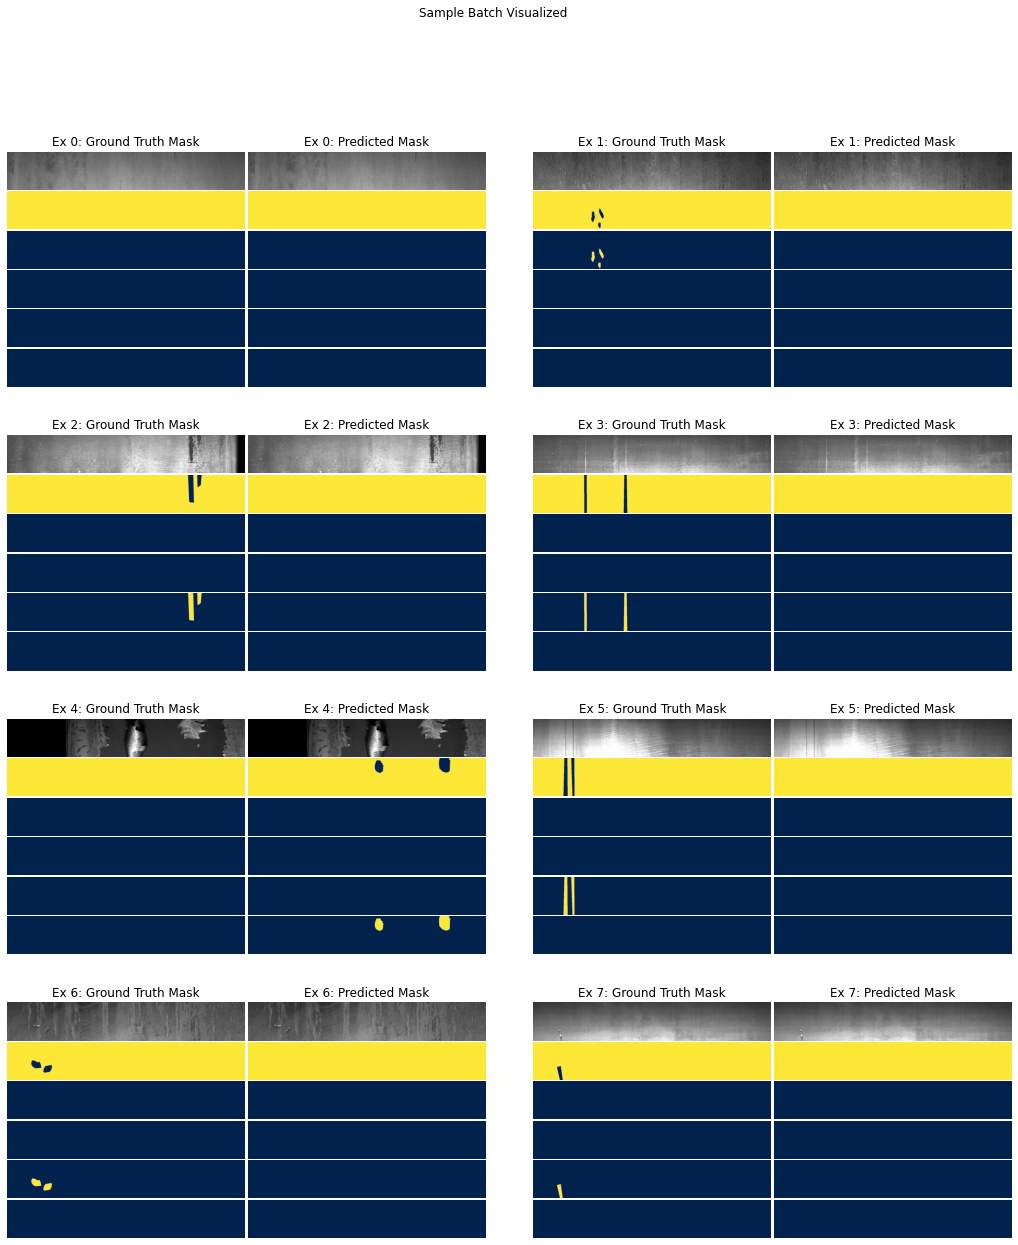

1/1 [==============================] - 15s 15s/step


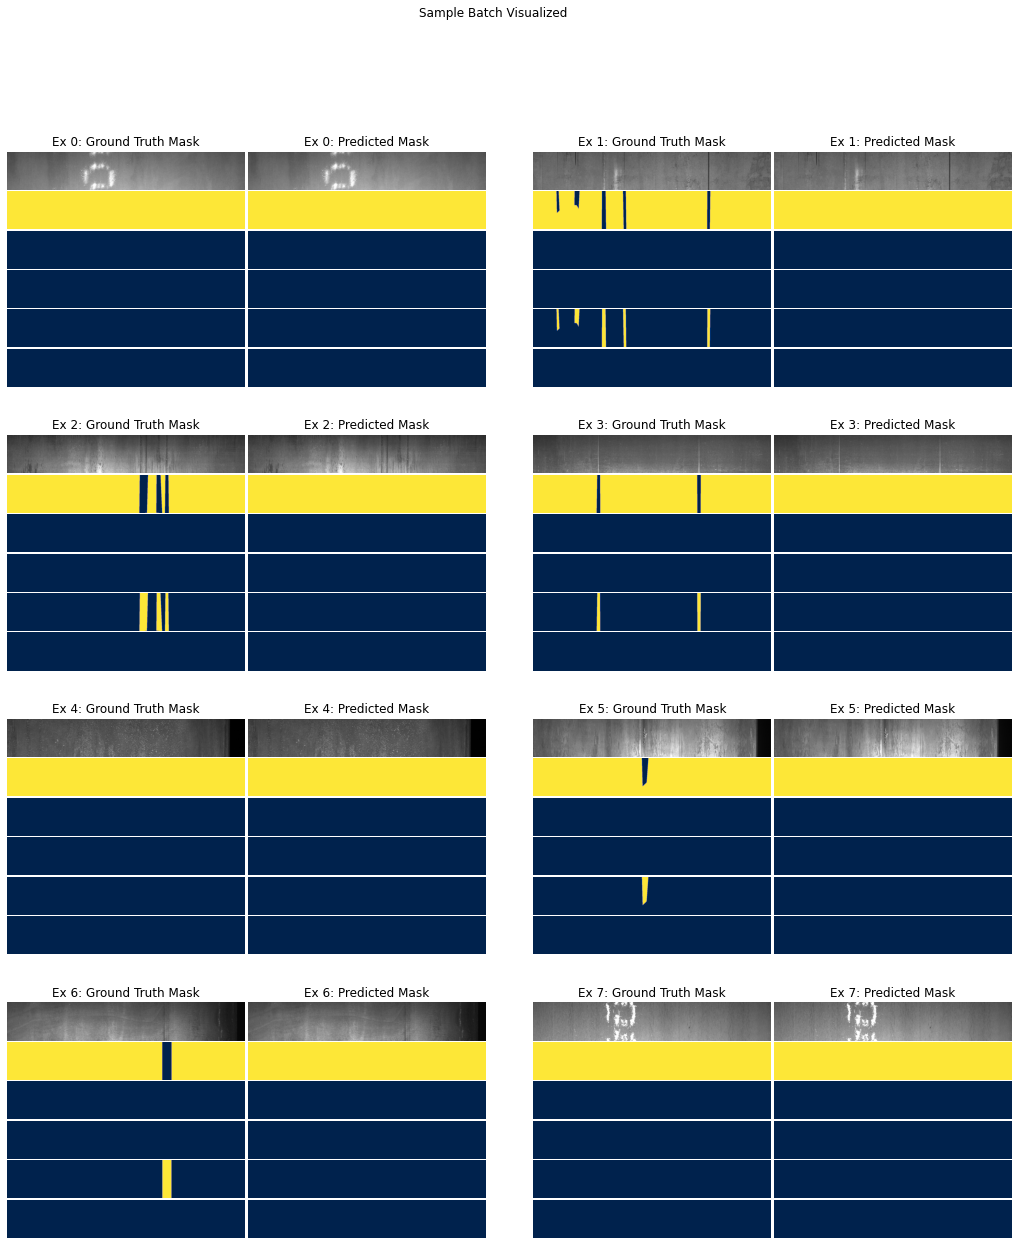

1/1 [==============================] - 14s 14s/step


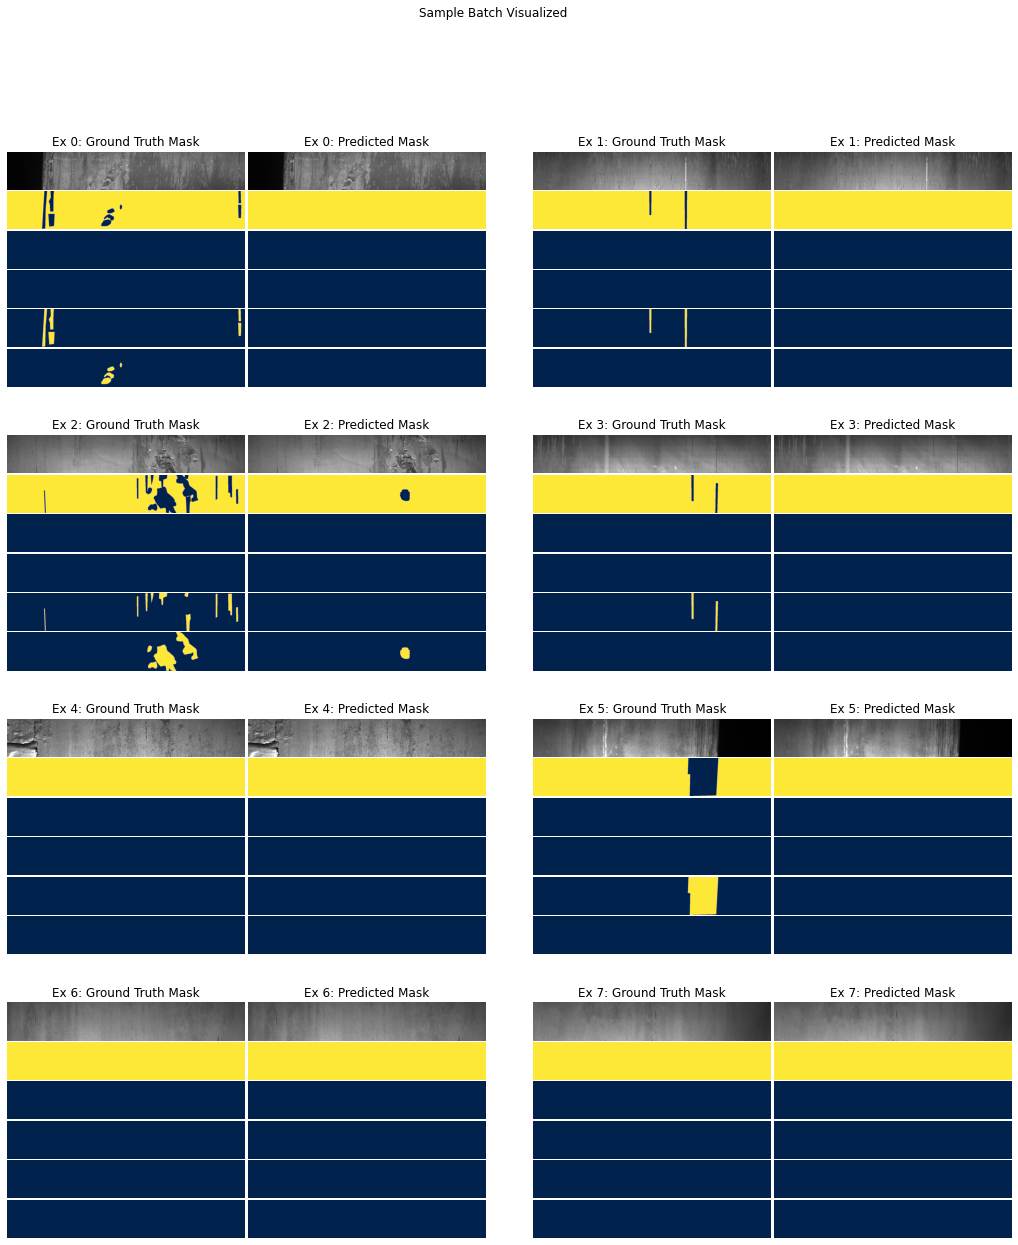

1/1 [==============================] - 14s 14s/step


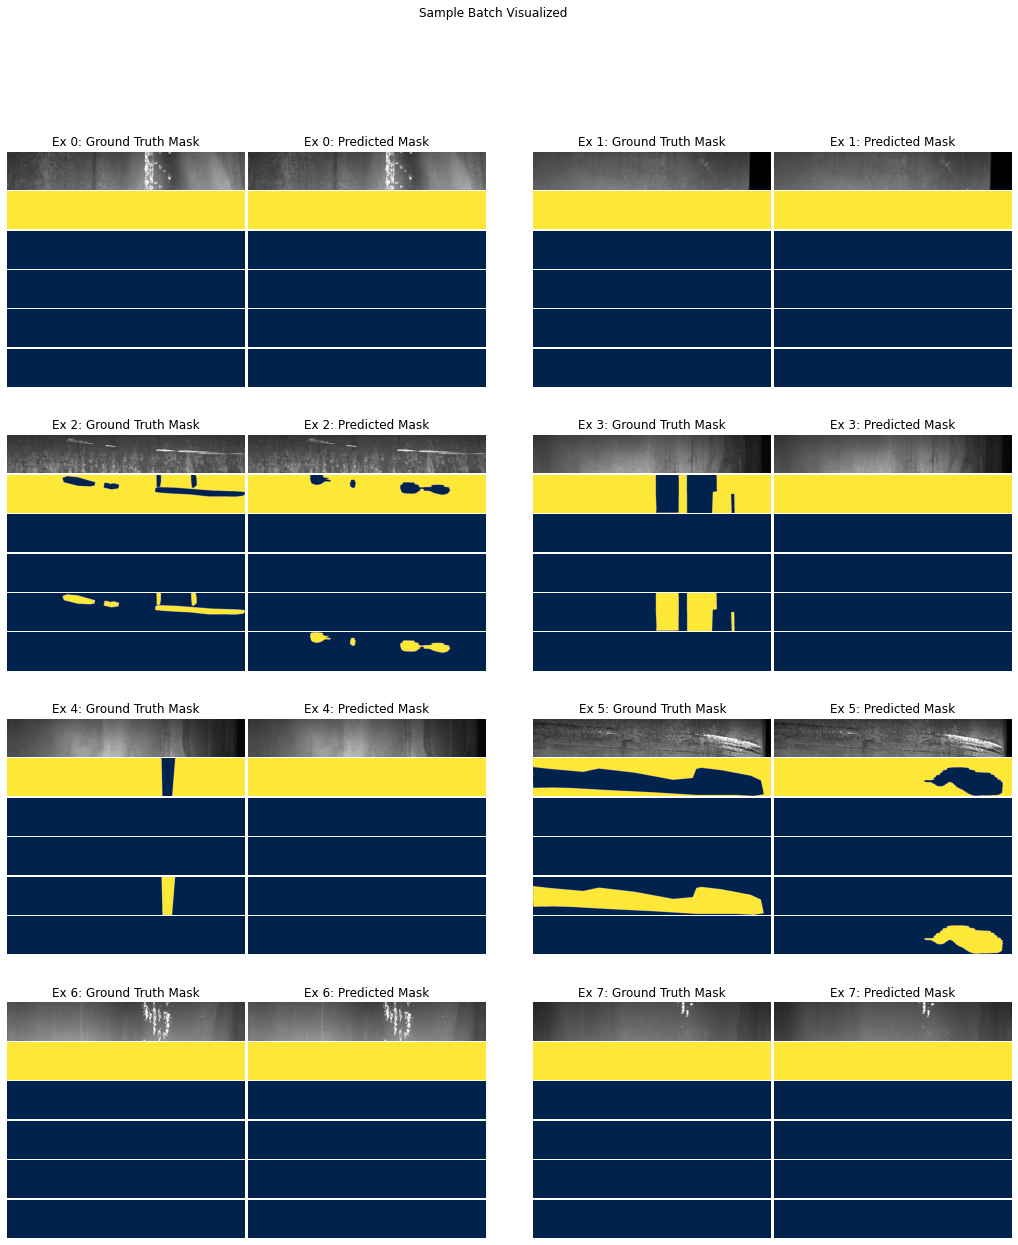

In [6]:
sample = list(test_dataset.take(4).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

    plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [18]:
class_scores = evaluate_per_class(test_dataset, unet_model, tversky_per_class)

  0%|          | 0/158 [00:00<?, ?it/s]

1/1 [==============================] - 1s 515ms/step


  1%|          | 1/158 [00:01<03:24,  1.30s/it]

1/1 [==============================] - 0s 147ms/step


  1%|▏         | 2/158 [00:01<02:14,  1.16it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▏         | 3/158 [00:02<01:52,  1.37it/s]

1/1 [==============================] - 0s 83ms/step


  3%|▎         | 4/158 [00:02<01:40,  1.53it/s]

1/1 [==============================] - 0s 80ms/step


  3%|▎         | 5/158 [00:03<01:33,  1.64it/s]

1/1 [==============================] - 0s 177ms/step


  4%|▍         | 6/158 [00:04<01:27,  1.73it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▍         | 7/158 [00:04<01:21,  1.84it/s]

1/1 [==============================] - 0s 87ms/step


  5%|▌         | 8/158 [00:04<01:19,  1.89it/s]

1/1 [==============================] - 0s 74ms/step


  6%|▌         | 9/158 [00:05<01:19,  1.87it/s]

1/1 [==============================] - 0s 171ms/step


  6%|▋         | 10/158 [00:06<01:18,  1.88it/s]

1/1 [==============================] - 0s 173ms/step


  7%|▋         | 11/158 [00:06<01:20,  1.83it/s]

1/1 [==============================] - 0s 172ms/step


  8%|▊         | 12/158 [00:07<01:19,  1.83it/s]

1/1 [==============================] - 0s 179ms/step


  8%|▊         | 13/158 [00:07<01:17,  1.87it/s]

1/1 [==============================] - 0s 171ms/step


  9%|▉         | 14/158 [00:08<01:17,  1.87it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 15/158 [00:08<01:15,  1.90it/s]

1/1 [==============================] - 0s 197ms/step


 10%|█         | 16/158 [00:09<01:14,  1.90it/s]

1/1 [==============================] - 0s 80ms/step


 11%|█         | 17/158 [00:09<01:11,  1.97it/s]

1/1 [==============================] - 0s 184ms/step


 11%|█▏        | 18/158 [00:10<01:14,  1.88it/s]

1/1 [==============================] - 0s 179ms/step


 12%|█▏        | 19/158 [00:10<01:15,  1.85it/s]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 20/158 [00:11<01:15,  1.84it/s]

1/1 [==============================] - 0s 171ms/step


 13%|█▎        | 21/158 [00:11<01:12,  1.88it/s]

1/1 [==============================] - 0s 175ms/step


 14%|█▍        | 22/158 [00:12<01:10,  1.94it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█▍        | 23/158 [00:12<01:09,  1.94it/s]

1/1 [==============================] - 0s 186ms/step


 15%|█▌        | 24/158 [00:13<01:09,  1.92it/s]

1/1 [==============================] - 0s 112ms/step


 16%|█▌        | 25/158 [00:13<01:09,  1.92it/s]

1/1 [==============================] - 0s 85ms/step


 16%|█▋        | 26/158 [00:14<01:07,  1.97it/s]

1/1 [==============================] - 0s 84ms/step


 17%|█▋        | 27/158 [00:14<01:05,  1.99it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 28/158 [00:15<01:03,  2.04it/s]

1/1 [==============================] - 0s 174ms/step


 18%|█▊        | 29/158 [00:15<01:02,  2.05it/s]

1/1 [==============================] - 0s 173ms/step


 19%|█▉        | 30/158 [00:16<01:02,  2.06it/s]

1/1 [==============================] - 0s 173ms/step


 20%|█▉        | 31/158 [00:16<01:01,  2.06it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 32/158 [00:17<01:01,  2.06it/s]

1/1 [==============================] - 0s 142ms/step


 21%|██        | 33/158 [00:17<01:02,  2.01it/s]

1/1 [==============================] - 0s 84ms/step


 22%|██▏       | 34/158 [00:18<01:00,  2.04it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 35/158 [00:18<01:01,  2.02it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 36/158 [00:19<01:01,  1.98it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 37/158 [00:19<00:59,  2.04it/s]

1/1 [==============================] - 0s 172ms/step


 24%|██▍       | 38/158 [00:20<00:58,  2.05it/s]

1/1 [==============================] - 0s 70ms/step


 25%|██▍       | 39/158 [00:20<00:57,  2.08it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▌       | 40/158 [00:21<00:56,  2.09it/s]

1/1 [==============================] - 0s 177ms/step


 26%|██▌       | 41/158 [00:21<00:56,  2.07it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 42/158 [00:22<00:56,  2.07it/s]

1/1 [==============================] - 0s 75ms/step


 27%|██▋       | 43/158 [00:22<00:56,  2.04it/s]

1/1 [==============================] - 0s 181ms/step


 28%|██▊       | 44/158 [00:23<00:56,  2.03it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██▊       | 45/158 [00:23<00:54,  2.06it/s]

1/1 [==============================] - 0s 189ms/step


 29%|██▉       | 46/158 [00:24<00:55,  2.03it/s]

1/1 [==============================] - 0s 144ms/step


 30%|██▉       | 47/158 [00:24<00:53,  2.07it/s]

1/1 [==============================] - 0s 79ms/step


 30%|███       | 48/158 [00:25<00:52,  2.09it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 49/158 [00:25<00:52,  2.09it/s]

1/1 [==============================] - 0s 87ms/step


 32%|███▏      | 50/158 [00:26<00:51,  2.08it/s]

1/1 [==============================] - 0s 117ms/step


 32%|███▏      | 51/158 [00:26<00:51,  2.10it/s]

1/1 [==============================] - 0s 84ms/step


 33%|███▎      | 52/158 [00:27<00:51,  2.05it/s]

1/1 [==============================] - 0s 81ms/step


 34%|███▎      | 53/158 [00:27<00:51,  2.03it/s]

1/1 [==============================] - 0s 73ms/step


 34%|███▍      | 54/158 [00:28<00:50,  2.06it/s]

1/1 [==============================] - 0s 71ms/step


 35%|███▍      | 55/158 [00:28<00:50,  2.06it/s]

1/1 [==============================] - 0s 79ms/step


 35%|███▌      | 56/158 [00:29<00:51,  1.97it/s]

1/1 [==============================] - 0s 82ms/step


 36%|███▌      | 57/158 [00:29<00:50,  1.99it/s]

1/1 [==============================] - 0s 181ms/step


 37%|███▋      | 58/158 [00:30<00:51,  1.96it/s]

1/1 [==============================] - 0s 85ms/step


 37%|███▋      | 59/158 [00:30<00:51,  1.90it/s]

1/1 [==============================] - 0s 77ms/step


 38%|███▊      | 60/158 [00:31<00:52,  1.88it/s]

1/1 [==============================] - 0s 176ms/step


 39%|███▊      | 61/158 [00:31<00:52,  1.86it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▉      | 62/158 [00:32<00:50,  1.89it/s]

1/1 [==============================] - 0s 174ms/step


 40%|███▉      | 63/158 [00:32<00:49,  1.92it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████      | 64/158 [00:33<00:50,  1.85it/s]

1/1 [==============================] - 0s 182ms/step


 41%|████      | 65/158 [00:33<00:49,  1.88it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 66/158 [00:34<00:47,  1.95it/s]

1/1 [==============================] - 0s 86ms/step


 42%|████▏     | 67/158 [00:34<00:46,  1.96it/s]

1/1 [==============================] - 0s 113ms/step


 43%|████▎     | 68/158 [00:35<00:46,  1.95it/s]

1/1 [==============================] - 0s 85ms/step


 44%|████▎     | 69/158 [00:35<00:45,  1.94it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▍     | 70/158 [00:36<00:44,  1.97it/s]

1/1 [==============================] - 0s 173ms/step


 45%|████▍     | 71/158 [00:36<00:45,  1.91it/s]

1/1 [==============================] - 0s 90ms/step


 46%|████▌     | 72/158 [00:37<00:44,  1.95it/s]

1/1 [==============================] - 0s 171ms/step


 46%|████▌     | 73/158 [00:37<00:43,  1.94it/s]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 74/158 [00:38<00:42,  1.97it/s]

1/1 [==============================] - 0s 182ms/step


 47%|████▋     | 75/158 [00:38<00:42,  1.98it/s]

1/1 [==============================] - 0s 166ms/step


 48%|████▊     | 76/158 [00:39<00:40,  2.01it/s]

1/1 [==============================] - 0s 163ms/step


 49%|████▊     | 77/158 [00:39<00:39,  2.04it/s]

1/1 [==============================] - 0s 75ms/step


 49%|████▉     | 78/158 [00:40<00:38,  2.08it/s]

1/1 [==============================] - 0s 77ms/step


 50%|█████     | 79/158 [00:40<00:38,  2.05it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████     | 80/158 [00:41<00:40,  1.93it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████▏    | 81/158 [00:41<00:40,  1.91it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████▏    | 82/158 [00:42<00:39,  1.95it/s]

1/1 [==============================] - 0s 85ms/step


 53%|█████▎    | 83/158 [00:42<00:37,  1.99it/s]

1/1 [==============================] - 0s 118ms/step


 53%|█████▎    | 84/158 [00:43<00:37,  2.00it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 85/158 [00:43<00:36,  2.02it/s]

1/1 [==============================] - 0s 111ms/step


 54%|█████▍    | 86/158 [00:44<00:36,  1.99it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▌    | 87/158 [00:44<00:35,  2.03it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 88/158 [00:45<00:33,  2.06it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▋    | 89/158 [00:45<00:33,  2.08it/s]

1/1 [==============================] - 0s 183ms/step


 57%|█████▋    | 90/158 [00:46<00:34,  1.99it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████▊    | 91/158 [00:46<00:33,  2.00it/s]

1/1 [==============================] - 0s 170ms/step


 58%|█████▊    | 92/158 [00:47<00:33,  2.00it/s]

1/1 [==============================] - 0s 78ms/step


 59%|█████▉    | 93/158 [00:47<00:31,  2.04it/s]

1/1 [==============================] - 0s 178ms/step


 59%|█████▉    | 94/158 [00:48<00:31,  2.04it/s]

1/1 [==============================] - 0s 86ms/step


 60%|██████    | 95/158 [00:48<00:30,  2.06it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████    | 96/158 [00:49<00:29,  2.08it/s]

1/1 [==============================] - 0s 71ms/step


 61%|██████▏   | 97/158 [00:49<00:28,  2.11it/s]

1/1 [==============================] - 0s 174ms/step


 62%|██████▏   | 98/158 [00:50<00:28,  2.11it/s]

1/1 [==============================] - 0s 172ms/step


 63%|██████▎   | 99/158 [00:50<00:28,  2.06it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 100/158 [00:51<00:29,  1.99it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 101/158 [00:51<00:28,  1.99it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 102/158 [00:52<00:27,  2.04it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▌   | 103/158 [00:52<00:26,  2.08it/s]

1/1 [==============================] - 0s 176ms/step


 66%|██████▌   | 104/158 [00:53<00:26,  2.07it/s]

1/1 [==============================] - 0s 85ms/step


 66%|██████▋   | 105/158 [00:53<00:25,  2.09it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 106/158 [00:54<00:25,  2.01it/s]

1/1 [==============================] - 0s 172ms/step


 68%|██████▊   | 107/158 [00:54<00:26,  1.92it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 108/158 [00:55<00:26,  1.88it/s]

1/1 [==============================] - 0s 174ms/step


 69%|██████▉   | 109/158 [00:55<00:26,  1.87it/s]

1/1 [==============================] - 0s 91ms/step


 70%|██████▉   | 110/158 [00:56<00:25,  1.91it/s]

1/1 [==============================] - 0s 72ms/step


 70%|███████   | 111/158 [00:56<00:24,  1.95it/s]

1/1 [==============================] - 0s 82ms/step


 71%|███████   | 112/158 [00:57<00:23,  1.96it/s]

1/1 [==============================] - 0s 177ms/step


 72%|███████▏  | 113/158 [00:57<00:22,  1.96it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████▏  | 114/158 [00:58<00:22,  1.99it/s]

1/1 [==============================] - 0s 174ms/step


 73%|███████▎  | 115/158 [00:58<00:22,  1.93it/s]

1/1 [==============================] - 0s 171ms/step


 73%|███████▎  | 116/158 [00:59<00:21,  1.95it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 117/158 [00:59<00:21,  1.95it/s]

1/1 [==============================] - 0s 112ms/step


 75%|███████▍  | 118/158 [01:00<00:20,  1.95it/s]

1/1 [==============================] - 0s 180ms/step


 75%|███████▌  | 119/158 [01:00<00:20,  1.94it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 120/158 [01:01<00:19,  1.99it/s]

1/1 [==============================] - 0s 176ms/step


 77%|███████▋  | 121/158 [01:01<00:18,  1.98it/s]

1/1 [==============================] - 0s 178ms/step


 77%|███████▋  | 122/158 [01:02<00:18,  1.90it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 123/158 [01:03<00:17,  1.95it/s]

1/1 [==============================] - 0s 177ms/step


 78%|███████▊  | 124/158 [01:03<00:17,  1.91it/s]

1/1 [==============================] - 0s 92ms/step


 79%|███████▉  | 125/158 [01:04<00:17,  1.90it/s]

1/1 [==============================] - 0s 75ms/step


 80%|███████▉  | 126/158 [01:04<00:16,  1.89it/s]

1/1 [==============================] - 0s 86ms/step


 80%|████████  | 127/158 [01:05<00:16,  1.84it/s]

1/1 [==============================] - 0s 102ms/step


 81%|████████  | 128/158 [01:05<00:15,  1.88it/s]

1/1 [==============================] - 0s 82ms/step


 82%|████████▏ | 129/158 [01:06<00:15,  1.90it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 130/158 [01:06<00:14,  1.97it/s]

1/1 [==============================] - 0s 170ms/step


 83%|████████▎ | 131/158 [01:07<00:13,  2.00it/s]

1/1 [==============================] - 0s 178ms/step


 84%|████████▎ | 132/158 [01:07<00:12,  2.01it/s]

1/1 [==============================] - 0s 81ms/step


 84%|████████▍ | 133/158 [01:08<00:12,  1.97it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████▍ | 134/158 [01:08<00:12,  1.95it/s]

1/1 [==============================] - 0s 165ms/step


 85%|████████▌ | 135/158 [01:09<00:12,  1.91it/s]

1/1 [==============================] - 0s 78ms/step


 86%|████████▌ | 136/158 [01:09<00:11,  1.97it/s]

1/1 [==============================] - 0s 89ms/step


 87%|████████▋ | 137/158 [01:10<00:10,  1.95it/s]

1/1 [==============================] - 0s 174ms/step


 87%|████████▋ | 138/158 [01:10<00:10,  1.96it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████▊ | 139/158 [01:11<00:09,  1.91it/s]

1/1 [==============================] - 0s 182ms/step


 89%|████████▊ | 140/158 [01:11<00:09,  1.88it/s]

1/1 [==============================] - 0s 83ms/step


 89%|████████▉ | 141/158 [01:12<00:09,  1.86it/s]

1/1 [==============================] - 0s 83ms/step


 90%|████████▉ | 142/158 [01:12<00:08,  1.88it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 143/158 [01:13<00:07,  1.95it/s]

1/1 [==============================] - 0s 75ms/step


 91%|█████████ | 144/158 [01:13<00:07,  1.96it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████▏| 145/158 [01:14<00:06,  1.90it/s]

1/1 [==============================] - 0s 184ms/step


 92%|█████████▏| 146/158 [01:15<00:06,  1.81it/s]

1/1 [==============================] - 0s 183ms/step


 93%|█████████▎| 147/158 [01:15<00:05,  1.87it/s]

1/1 [==============================] - 0s 185ms/step


 94%|█████████▎| 148/158 [01:16<00:05,  1.89it/s]

1/1 [==============================] - 0s 138ms/step


 94%|█████████▍| 149/158 [01:16<00:04,  1.90it/s]

1/1 [==============================] - 0s 171ms/step


 95%|█████████▍| 150/158 [01:17<00:04,  1.95it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 151/158 [01:17<00:03,  1.98it/s]

1/1 [==============================] - 0s 182ms/step


 96%|█████████▌| 152/158 [01:18<00:03,  1.94it/s]

1/1 [==============================] - 0s 88ms/step


 97%|█████████▋| 153/158 [01:18<00:02,  1.95it/s]

1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 154/158 [01:19<00:02,  1.93it/s]

1/1 [==============================] - 0s 183ms/step


 98%|█████████▊| 155/158 [01:19<00:01,  1.94it/s]

1/1 [==============================] - 0s 184ms/step


 99%|█████████▊| 156/158 [01:20<00:01,  1.92it/s]

1/1 [==============================] - 0s 80ms/step


 99%|█████████▉| 157/158 [01:20<00:00,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 158/158 [01:20<00:00,  1.95it/s]


In [19]:
class_scores

{0: 0.9873903, 1: 0.55696166, 2: 0.86708844, 3: 0.012658228, 4: 0.21458836}

#### unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_True-20221020-064906
- Tversky Loss with "all positive" Sample Weighting
- Doesn't learn anything other than background

{
            -2: 10,
            -1: 1.0,
            1: 2.0,
            2: 8.0,
            3: 1.0,
            4: 4.0,
        }

In [20]:
MODEL_PATH = "../logs/unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_True-20221020-064906/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

1/1 [==============================] - 16s 16s/step


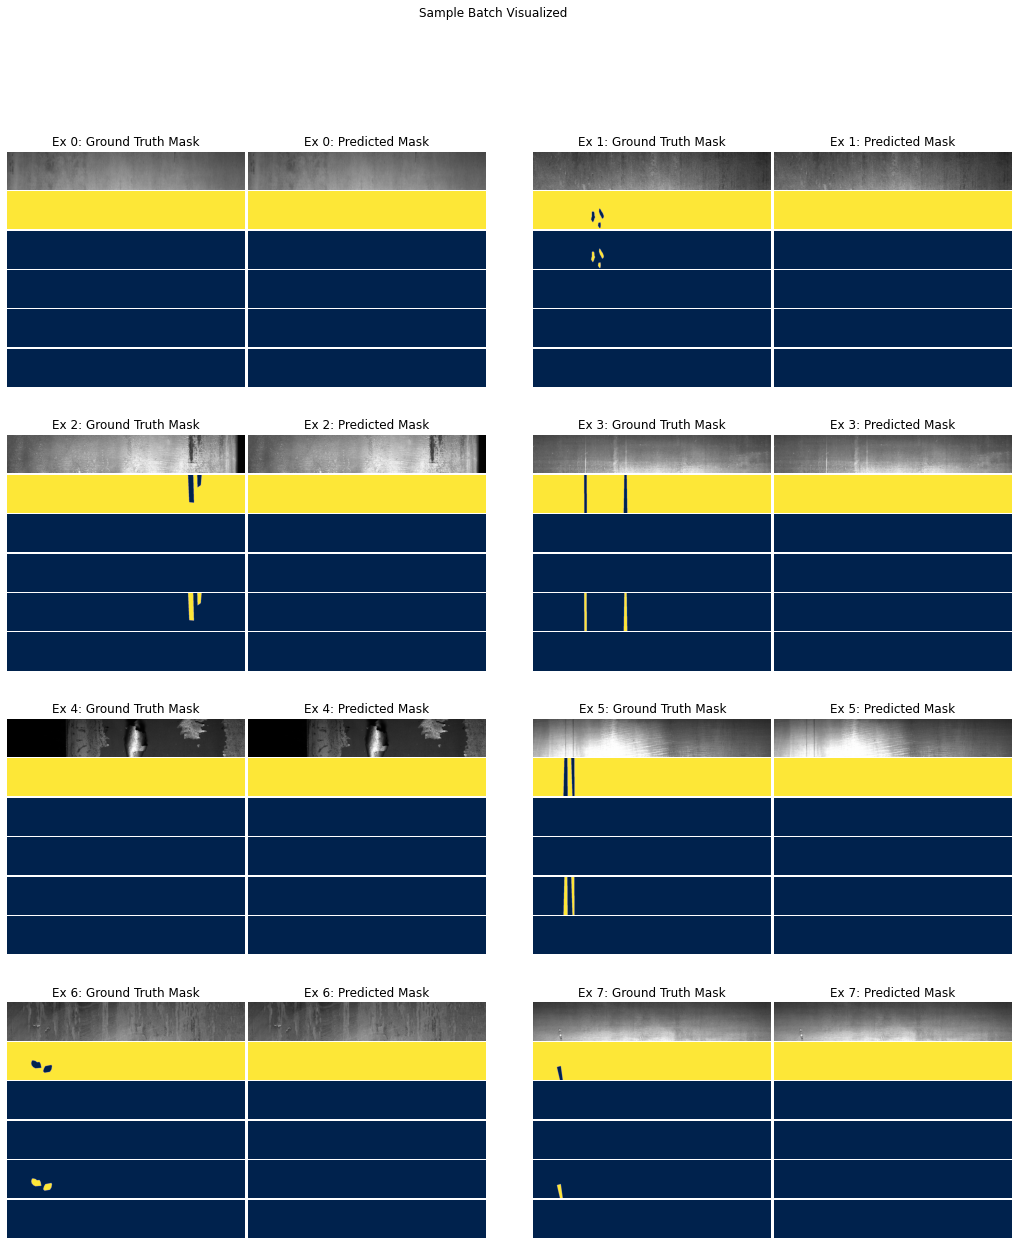

1/1 [==============================] - 13s 13s/step


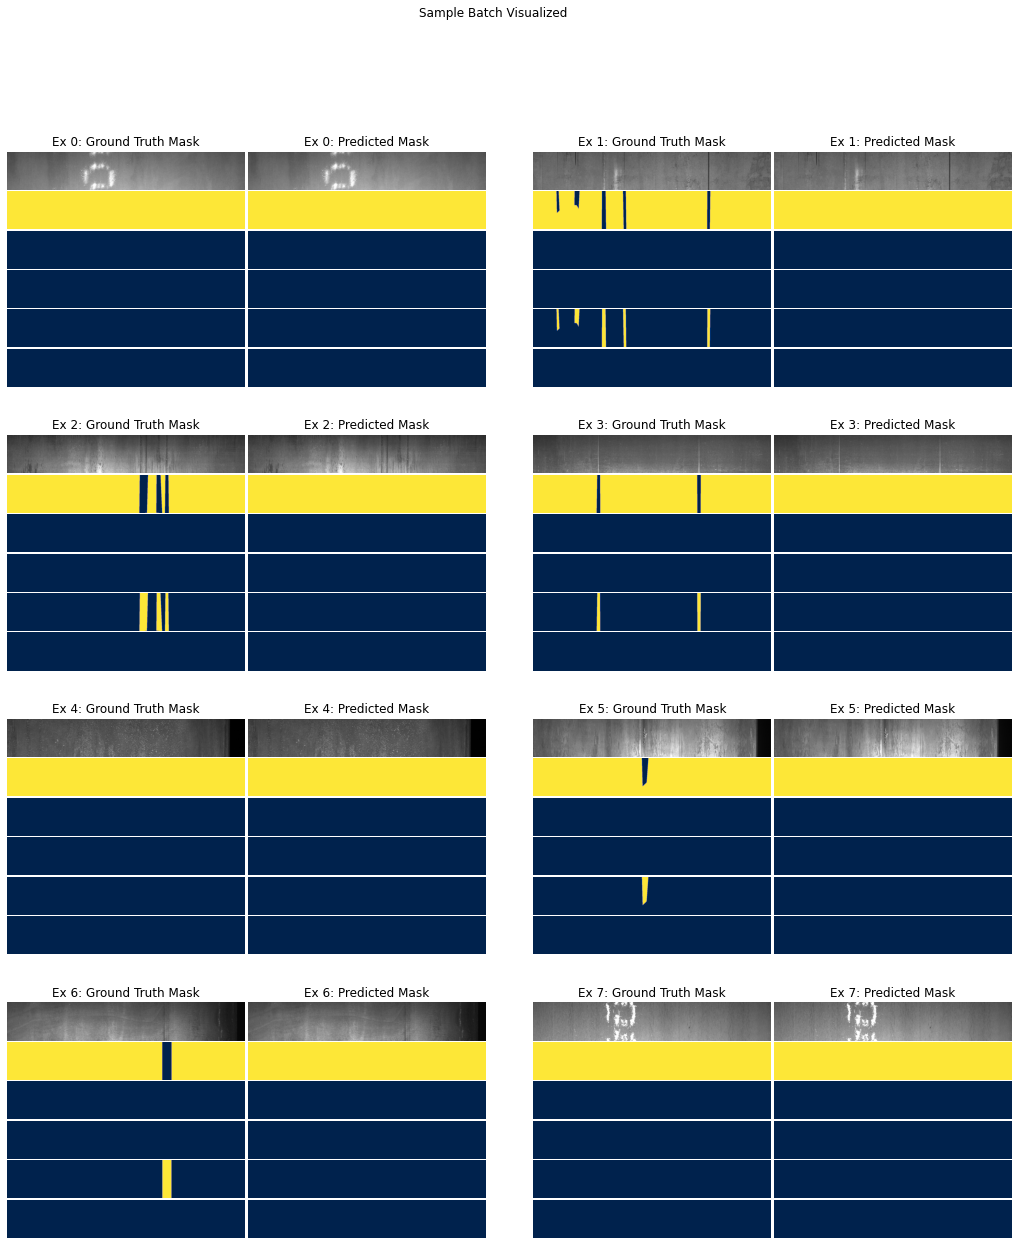

1/1 [==============================] - 14s 14s/step


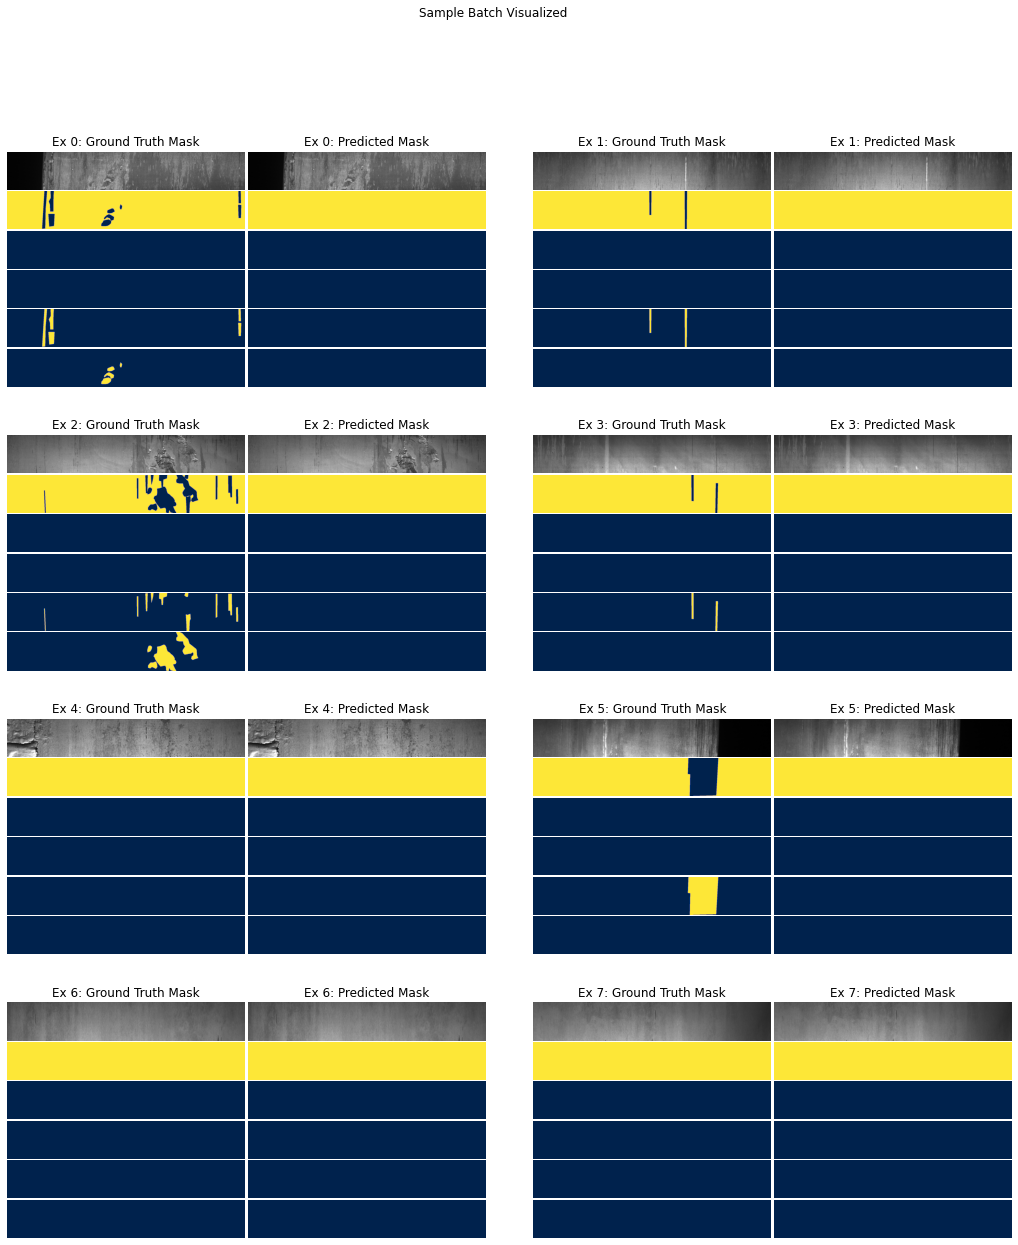

1/1 [==============================] - 13s 13s/step


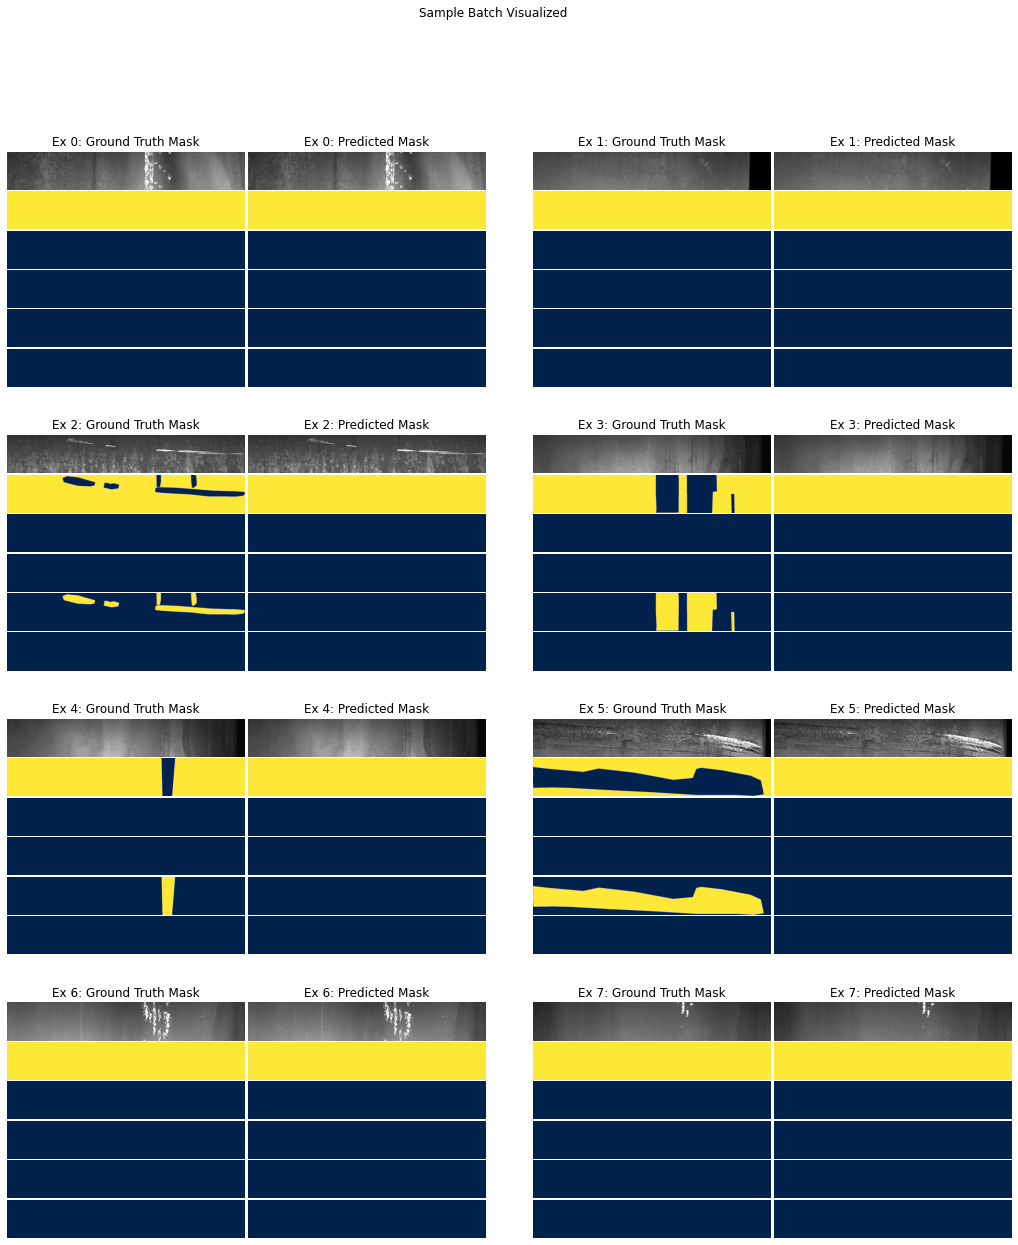

In [8]:
sample = list(test_dataset.take(4).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

    plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [21]:
class_scores = evaluate_per_class(test_dataset, unet_model, tversky_per_class)

  0%|          | 0/158 [00:00<?, ?it/s]

1/1 [==============================] - 0s 480ms/step


  1%|          | 1/158 [00:01<03:12,  1.22s/it]

1/1 [==============================] - 0s 171ms/step


  1%|▏         | 2/158 [00:01<02:05,  1.24it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 3/158 [00:02<01:44,  1.48it/s]

1/1 [==============================] - 0s 90ms/step


  3%|▎         | 4/158 [00:02<01:33,  1.66it/s]

1/1 [==============================] - 0s 175ms/step


  3%|▎         | 5/158 [00:03<01:27,  1.75it/s]

1/1 [==============================] - 0s 91ms/step


  4%|▍         | 6/158 [00:03<01:23,  1.82it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 7/158 [00:04<01:53,  1.33it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 8/158 [00:05<01:44,  1.43it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 9/158 [00:06<01:34,  1.58it/s]

1/1 [==============================] - 0s 86ms/step


  6%|▋         | 10/158 [00:06<01:27,  1.70it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 11/158 [00:06<01:21,  1.80it/s]

1/1 [==============================] - 0s 183ms/step


  8%|▊         | 12/158 [00:07<01:20,  1.82it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 13/158 [00:08<01:20,  1.79it/s]

1/1 [==============================] - 0s 117ms/step


  9%|▉         | 14/158 [00:08<01:18,  1.83it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▉         | 15/158 [00:09<01:18,  1.83it/s]

1/1 [==============================] - 0s 100ms/step


 10%|█         | 16/158 [00:09<01:15,  1.87it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 17/158 [00:10<01:12,  1.96it/s]

1/1 [==============================] - 0s 105ms/step


 11%|█▏        | 18/158 [00:10<01:15,  1.86it/s]

1/1 [==============================] - 0s 106ms/step


 12%|█▏        | 19/158 [00:11<01:11,  1.95it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 20/158 [00:11<01:11,  1.94it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 21/158 [00:12<01:13,  1.87it/s]

1/1 [==============================] - 0s 109ms/step


 14%|█▍        | 22/158 [00:12<01:10,  1.93it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█▍        | 23/158 [00:13<01:10,  1.93it/s]

1/1 [==============================] - 0s 194ms/step


 15%|█▌        | 24/158 [00:13<01:09,  1.94it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▌        | 25/158 [00:14<01:09,  1.91it/s]

1/1 [==============================] - 0s 190ms/step


 16%|█▋        | 26/158 [00:14<01:08,  1.93it/s]

1/1 [==============================] - 0s 200ms/step


 17%|█▋        | 27/158 [00:15<01:08,  1.91it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 28/158 [00:15<01:05,  2.00it/s]

1/1 [==============================] - 0s 92ms/step


 18%|█▊        | 29/158 [00:16<01:04,  2.00it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 30/158 [00:16<01:04,  1.98it/s]

1/1 [==============================] - 0s 82ms/step


 20%|█▉        | 31/158 [00:17<01:03,  1.99it/s]

1/1 [==============================] - 0s 183ms/step


 20%|██        | 32/158 [00:17<01:04,  1.95it/s]

1/1 [==============================] - 0s 177ms/step


 21%|██        | 33/158 [00:18<01:04,  1.94it/s]

1/1 [==============================] - 0s 177ms/step


 22%|██▏       | 34/158 [00:18<01:04,  1.94it/s]

1/1 [==============================] - 0s 97ms/step


 22%|██▏       | 35/158 [00:19<01:03,  1.95it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 36/158 [00:19<01:02,  1.95it/s]

1/1 [==============================] - 0s 184ms/step


 23%|██▎       | 37/158 [00:20<01:04,  1.87it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 38/158 [00:20<01:02,  1.93it/s]

1/1 [==============================] - 0s 183ms/step


 25%|██▍       | 39/158 [00:21<01:01,  1.92it/s]

1/1 [==============================] - 0s 87ms/step


 25%|██▌       | 40/158 [00:22<01:00,  1.93it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 41/158 [00:22<01:01,  1.90it/s]

1/1 [==============================] - 0s 94ms/step


 27%|██▋       | 42/158 [00:23<01:00,  1.92it/s]

1/1 [==============================] - 0s 95ms/step


 27%|██▋       | 43/158 [00:23<01:01,  1.87it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 44/158 [00:24<01:00,  1.88it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 45/158 [00:24<01:00,  1.88it/s]

1/1 [==============================] - 0s 180ms/step


 29%|██▉       | 46/158 [00:25<00:59,  1.88it/s]

1/1 [==============================] - 0s 102ms/step


 30%|██▉       | 47/158 [00:25<01:01,  1.80it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███       | 48/158 [00:26<01:02,  1.76it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 49/158 [00:26<00:59,  1.82it/s]

1/1 [==============================] - 0s 89ms/step


 32%|███▏      | 50/158 [00:27<00:59,  1.83it/s]

1/1 [==============================] - 0s 93ms/step


 32%|███▏      | 51/158 [00:27<00:56,  1.89it/s]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 52/158 [00:28<00:57,  1.85it/s]

1/1 [==============================] - 0s 181ms/step


 34%|███▎      | 53/158 [00:29<00:58,  1.80it/s]

1/1 [==============================] - 0s 189ms/step


 34%|███▍      | 54/158 [00:29<00:56,  1.83it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███▍      | 55/158 [00:30<00:54,  1.87it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▌      | 56/158 [00:30<00:53,  1.89it/s]

1/1 [==============================] - 0s 97ms/step


 36%|███▌      | 57/158 [00:31<00:53,  1.90it/s]

1/1 [==============================] - 0s 91ms/step


 37%|███▋      | 58/158 [00:31<00:51,  1.95it/s]

1/1 [==============================] - 0s 186ms/step


 37%|███▋      | 59/158 [00:32<00:52,  1.90it/s]

1/1 [==============================] - 0s 110ms/step


 38%|███▊      | 60/158 [00:32<00:50,  1.93it/s]

1/1 [==============================] - 0s 91ms/step


 39%|███▊      | 61/158 [00:33<00:50,  1.92it/s]

1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 62/158 [00:33<00:49,  1.96it/s]

1/1 [==============================] - 0s 180ms/step


 40%|███▉      | 63/158 [00:34<00:49,  1.93it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████      | 64/158 [00:34<00:47,  1.96it/s]

1/1 [==============================] - 0s 78ms/step


 41%|████      | 65/158 [00:35<00:46,  1.98it/s]

1/1 [==============================] - 0s 184ms/step


 42%|████▏     | 66/158 [00:35<00:47,  1.93it/s]

1/1 [==============================] - 0s 178ms/step


 42%|████▏     | 67/158 [00:36<00:48,  1.89it/s]

1/1 [==============================] - 0s 90ms/step


 43%|████▎     | 68/158 [00:36<00:48,  1.87it/s]

1/1 [==============================] - 0s 78ms/step


 44%|████▎     | 69/158 [00:37<00:46,  1.92it/s]

1/1 [==============================] - 0s 187ms/step


 44%|████▍     | 70/158 [00:37<00:46,  1.91it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▍     | 71/158 [00:38<00:45,  1.92it/s]

1/1 [==============================] - 0s 178ms/step


 46%|████▌     | 72/158 [00:38<00:44,  1.92it/s]

1/1 [==============================] - 0s 176ms/step


 46%|████▌     | 73/158 [00:39<00:45,  1.87it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 74/158 [00:40<00:43,  1.92it/s]

1/1 [==============================] - 0s 175ms/step


 47%|████▋     | 75/158 [00:40<00:42,  1.94it/s]

1/1 [==============================] - 0s 173ms/step


 48%|████▊     | 76/158 [00:41<00:41,  1.97it/s]

1/1 [==============================] - 0s 83ms/step


 49%|████▊     | 77/158 [00:41<00:41,  1.95it/s]

1/1 [==============================] - 0s 180ms/step


 49%|████▉     | 78/158 [00:42<00:41,  1.95it/s]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 79/158 [00:42<00:39,  1.99it/s]

1/1 [==============================] - 0s 169ms/step


 51%|█████     | 80/158 [00:43<00:39,  1.99it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████▏    | 81/158 [00:43<00:38,  2.00it/s]

1/1 [==============================] - 0s 183ms/step


 52%|█████▏    | 82/158 [00:44<00:38,  2.00it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 83/158 [00:44<00:38,  1.97it/s]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 84/158 [00:45<00:36,  2.01it/s]

1/1 [==============================] - 0s 113ms/step


 54%|█████▍    | 85/158 [00:45<00:35,  2.03it/s]

1/1 [==============================] - 0s 186ms/step


 54%|█████▍    | 86/158 [00:46<00:36,  1.97it/s]

1/1 [==============================] - 0s 83ms/step


 55%|█████▌    | 87/158 [00:46<00:35,  2.02it/s]

1/1 [==============================] - 0s 174ms/step


 56%|█████▌    | 88/158 [00:47<00:34,  2.03it/s]

1/1 [==============================] - 0s 115ms/step


 56%|█████▋    | 89/158 [00:47<00:33,  2.06it/s]

1/1 [==============================] - 0s 177ms/step


 57%|█████▋    | 90/158 [00:47<00:33,  2.04it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 91/158 [00:48<00:33,  2.02it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 92/158 [00:49<00:33,  1.97it/s]

1/1 [==============================] - 0s 87ms/step


 59%|█████▉    | 93/158 [00:49<00:33,  1.94it/s]

1/1 [==============================] - 0s 186ms/step


 59%|█████▉    | 94/158 [00:50<00:32,  1.94it/s]

1/1 [==============================] - 0s 131ms/step


 60%|██████    | 95/158 [00:50<00:33,  1.89it/s]

1/1 [==============================] - 0s 83ms/step


 61%|██████    | 96/158 [00:51<00:31,  1.95it/s]

1/1 [==============================] - 0s 100ms/step


 61%|██████▏   | 97/158 [00:51<00:32,  1.90it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 98/158 [00:52<00:31,  1.90it/s]

1/1 [==============================] - 0s 185ms/step


 63%|██████▎   | 99/158 [00:52<00:31,  1.85it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 100/158 [00:53<00:31,  1.83it/s]

1/1 [==============================] - 0s 186ms/step


 64%|██████▍   | 101/158 [00:53<00:30,  1.88it/s]

1/1 [==============================] - 0s 90ms/step


 65%|██████▍   | 102/158 [00:54<00:29,  1.91it/s]

1/1 [==============================] - 0s 197ms/step


 65%|██████▌   | 103/158 [00:54<00:29,  1.83it/s]

1/1 [==============================] - 0s 102ms/step


 66%|██████▌   | 104/158 [00:55<00:28,  1.87it/s]

1/1 [==============================] - 0s 177ms/step


 66%|██████▋   | 105/158 [00:56<00:29,  1.80it/s]

1/1 [==============================] - 0s 190ms/step


 67%|██████▋   | 106/158 [00:56<00:29,  1.77it/s]

1/1 [==============================] - 0s 89ms/step


 68%|██████▊   | 107/158 [00:57<00:28,  1.78it/s]

1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 108/158 [00:57<00:27,  1.84it/s]

1/1 [==============================] - 0s 177ms/step


 69%|██████▉   | 109/158 [00:58<00:26,  1.82it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████▉   | 110/158 [00:58<00:26,  1.83it/s]

1/1 [==============================] - 0s 179ms/step


 70%|███████   | 111/158 [00:59<00:25,  1.81it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 112/158 [00:59<00:25,  1.82it/s]

1/1 [==============================] - 0s 100ms/step


 72%|███████▏  | 113/158 [01:00<00:24,  1.82it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 114/158 [01:00<00:23,  1.85it/s]

1/1 [==============================] - 0s 119ms/step


 73%|███████▎  | 115/158 [01:01<00:23,  1.86it/s]

1/1 [==============================] - 0s 86ms/step


 73%|███████▎  | 116/158 [01:02<00:22,  1.84it/s]

1/1 [==============================] - 0s 181ms/step


 74%|███████▍  | 117/158 [01:02<00:22,  1.83it/s]

1/1 [==============================] - 0s 88ms/step


 75%|███████▍  | 118/158 [01:03<00:22,  1.82it/s]

1/1 [==============================] - 0s 183ms/step


 75%|███████▌  | 119/158 [01:03<00:21,  1.81it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████▌  | 120/158 [01:04<00:20,  1.82it/s]

1/1 [==============================] - 0s 86ms/step


 77%|███████▋  | 121/158 [01:04<00:20,  1.84it/s]

1/1 [==============================] - 0s 115ms/step


 77%|███████▋  | 122/158 [01:05<00:19,  1.83it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 123/158 [01:05<00:19,  1.84it/s]

1/1 [==============================] - 0s 179ms/step


 78%|███████▊  | 124/158 [01:06<00:17,  1.89it/s]

1/1 [==============================] - 0s 80ms/step


 79%|███████▉  | 125/158 [01:06<00:17,  1.92it/s]

1/1 [==============================] - 0s 92ms/step


 80%|███████▉  | 126/158 [01:07<00:16,  1.90it/s]

1/1 [==============================] - 0s 78ms/step


 80%|████████  | 127/158 [01:07<00:15,  1.95it/s]

1/1 [==============================] - 0s 177ms/step


 81%|████████  | 128/158 [01:08<00:15,  1.97it/s]

1/1 [==============================] - 0s 109ms/step


 82%|████████▏ | 129/158 [01:08<00:14,  1.93it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 130/158 [01:09<00:14,  1.91it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 131/158 [01:10<00:14,  1.90it/s]

1/1 [==============================] - 0s 177ms/step


 84%|████████▎ | 132/158 [01:10<00:13,  1.93it/s]

1/1 [==============================] - 0s 176ms/step


 84%|████████▍ | 133/158 [01:11<00:13,  1.91it/s]

1/1 [==============================] - 0s 79ms/step


 85%|████████▍ | 134/158 [01:11<00:12,  1.91it/s]

1/1 [==============================] - 0s 80ms/step


 85%|████████▌ | 135/158 [01:12<00:12,  1.90it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 136/158 [01:12<00:11,  1.94it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████▋ | 137/158 [01:13<00:10,  1.96it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████▋ | 138/158 [01:13<00:10,  1.90it/s]

1/1 [==============================] - 0s 180ms/step


 88%|████████▊ | 139/158 [01:14<00:10,  1.86it/s]

1/1 [==============================] - 0s 80ms/step


 89%|████████▊ | 140/158 [01:14<00:09,  1.85it/s]

1/1 [==============================] - 0s 193ms/step


 89%|████████▉ | 141/158 [01:15<00:09,  1.82it/s]

1/1 [==============================] - 0s 179ms/step


 90%|████████▉ | 142/158 [01:15<00:08,  1.82it/s]

1/1 [==============================] - 0s 80ms/step


 91%|█████████ | 143/158 [01:16<00:07,  1.88it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████ | 144/158 [01:16<00:07,  1.83it/s]

1/1 [==============================] - 0s 174ms/step


 92%|█████████▏| 145/158 [01:17<00:07,  1.81it/s]

1/1 [==============================] - 0s 81ms/step


 92%|█████████▏| 146/158 [01:18<00:06,  1.83it/s]

1/1 [==============================] - 0s 174ms/step


 93%|█████████▎| 147/158 [01:18<00:06,  1.83it/s]

1/1 [==============================] - 0s 183ms/step


 94%|█████████▎| 148/158 [01:19<00:05,  1.82it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▍| 149/158 [01:19<00:04,  1.85it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▍| 150/158 [01:20<00:04,  1.88it/s]

1/1 [==============================] - 0s 166ms/step


 96%|█████████▌| 151/158 [01:20<00:03,  1.85it/s]

1/1 [==============================] - 0s 180ms/step


 96%|█████████▌| 152/158 [01:21<00:03,  1.89it/s]

1/1 [==============================] - 0s 90ms/step


 97%|█████████▋| 153/158 [01:21<00:02,  1.92it/s]

1/1 [==============================] - 0s 81ms/step


 97%|█████████▋| 154/158 [01:22<00:02,  1.97it/s]

1/1 [==============================] - 0s 112ms/step


 98%|█████████▊| 155/158 [01:22<00:01,  1.99it/s]

1/1 [==============================] - 0s 108ms/step


 99%|█████████▊| 156/158 [01:23<00:00,  2.02it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 157/158 [01:23<00:00,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 158/158 [01:23<00:00,  1.88it/s]


In [22]:
class_scores

{0: 0.99046683, 1: 0.556962, 2: 0.8670886, 3: 0.012658228, 4: 0.5443038}

## Sample Weighting Experiments

#### tversky_loss, no sample weighting

unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_False-strategy_ens-beta_0.999-small_sample_True-20221021-155208

In [3]:
MODEL_PATH = "../logs_sw_experiment/unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss-sw_False-strategy_ens-beta_0.999-small_sample_True-20221021-130628/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

2022-10-21 16:15:39.176277: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 13s 13s/step


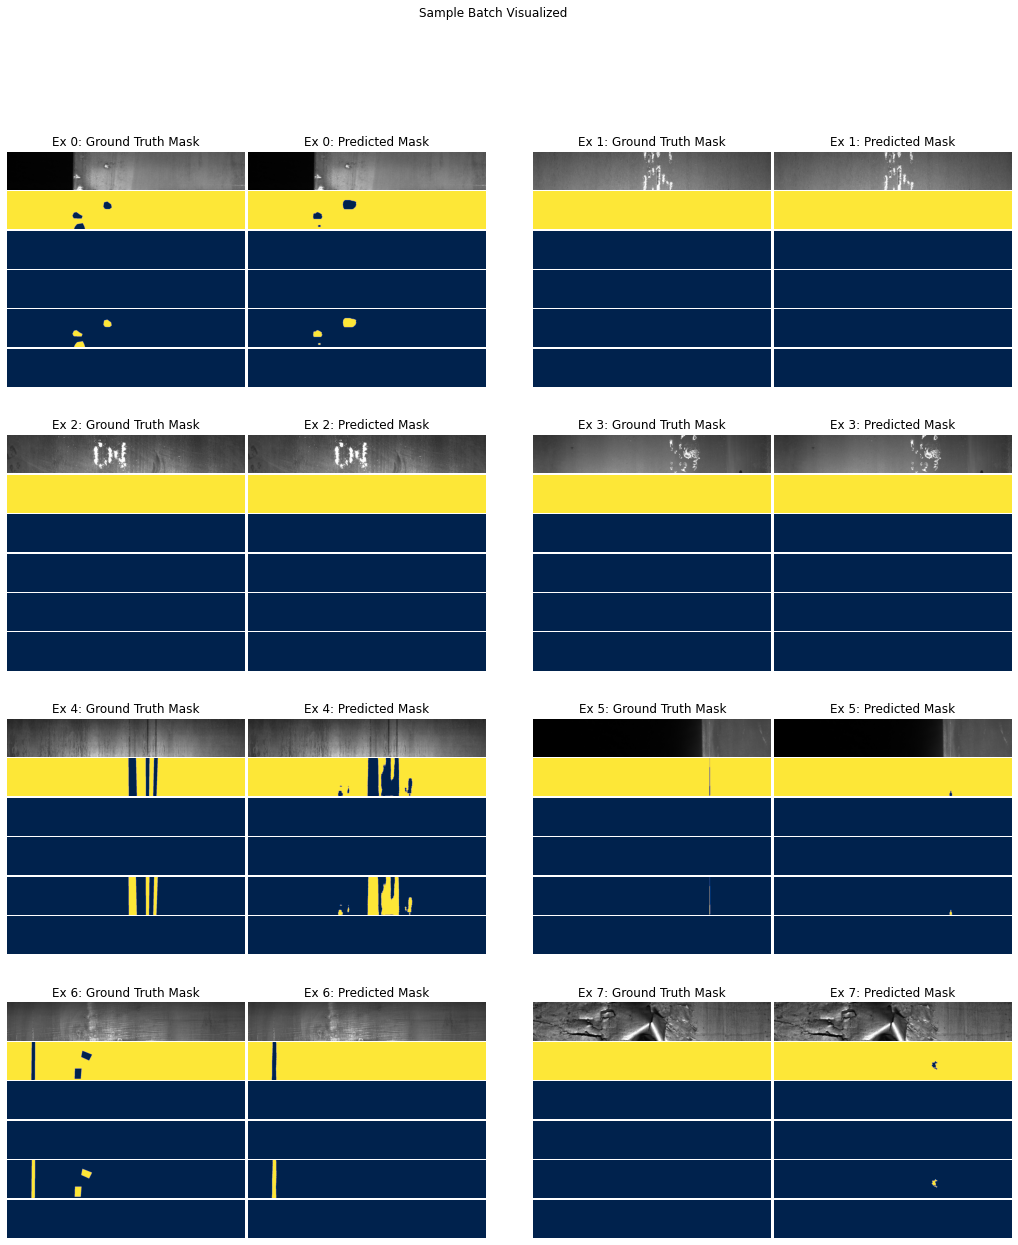

2022-10-21 16:16:03.693522: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 11s 11s/step


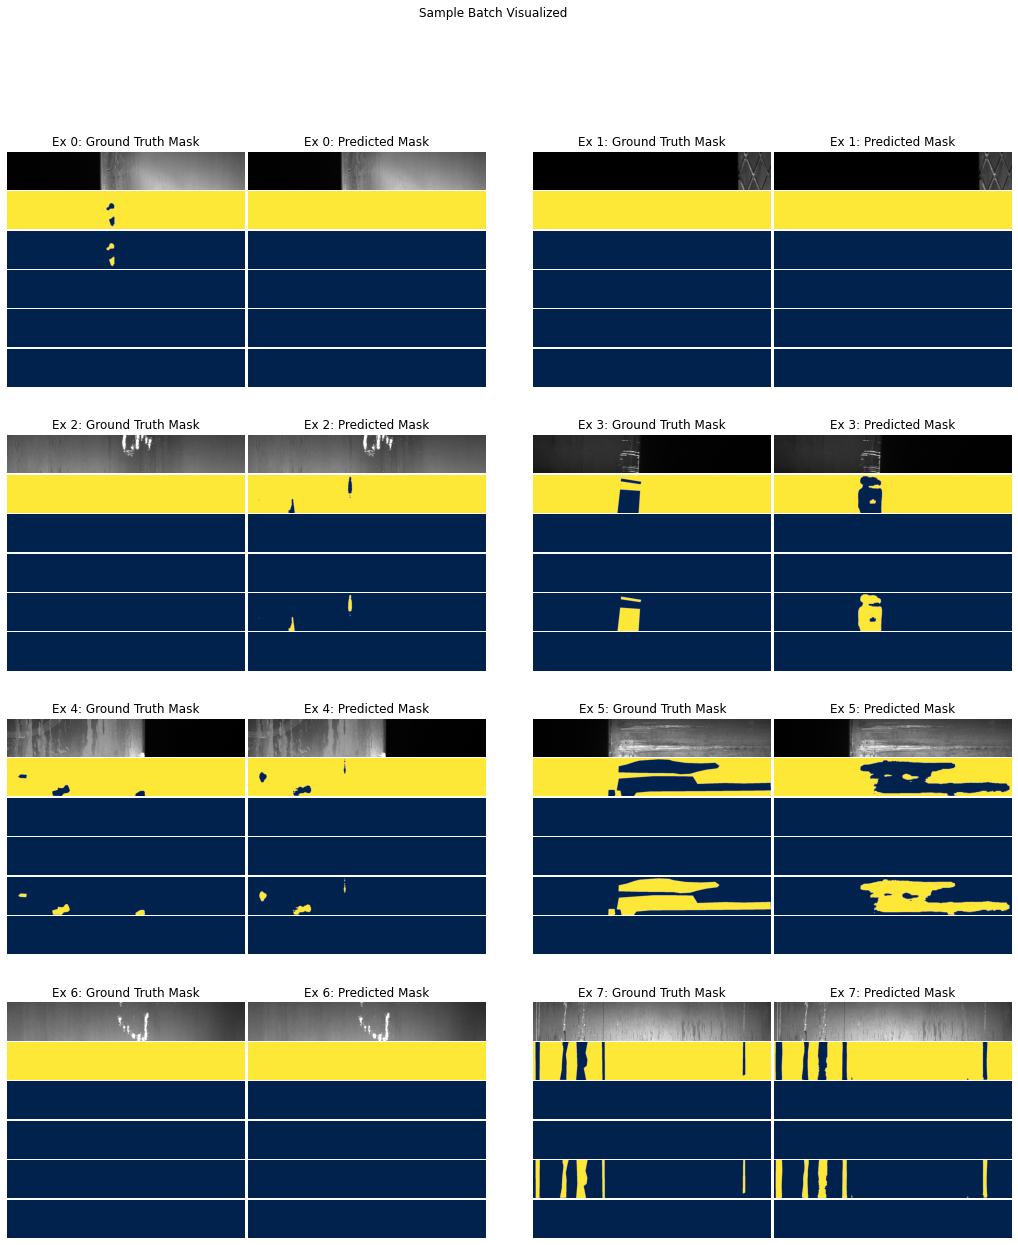

2022-10-21 16:16:28.611022: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 11s 11s/step


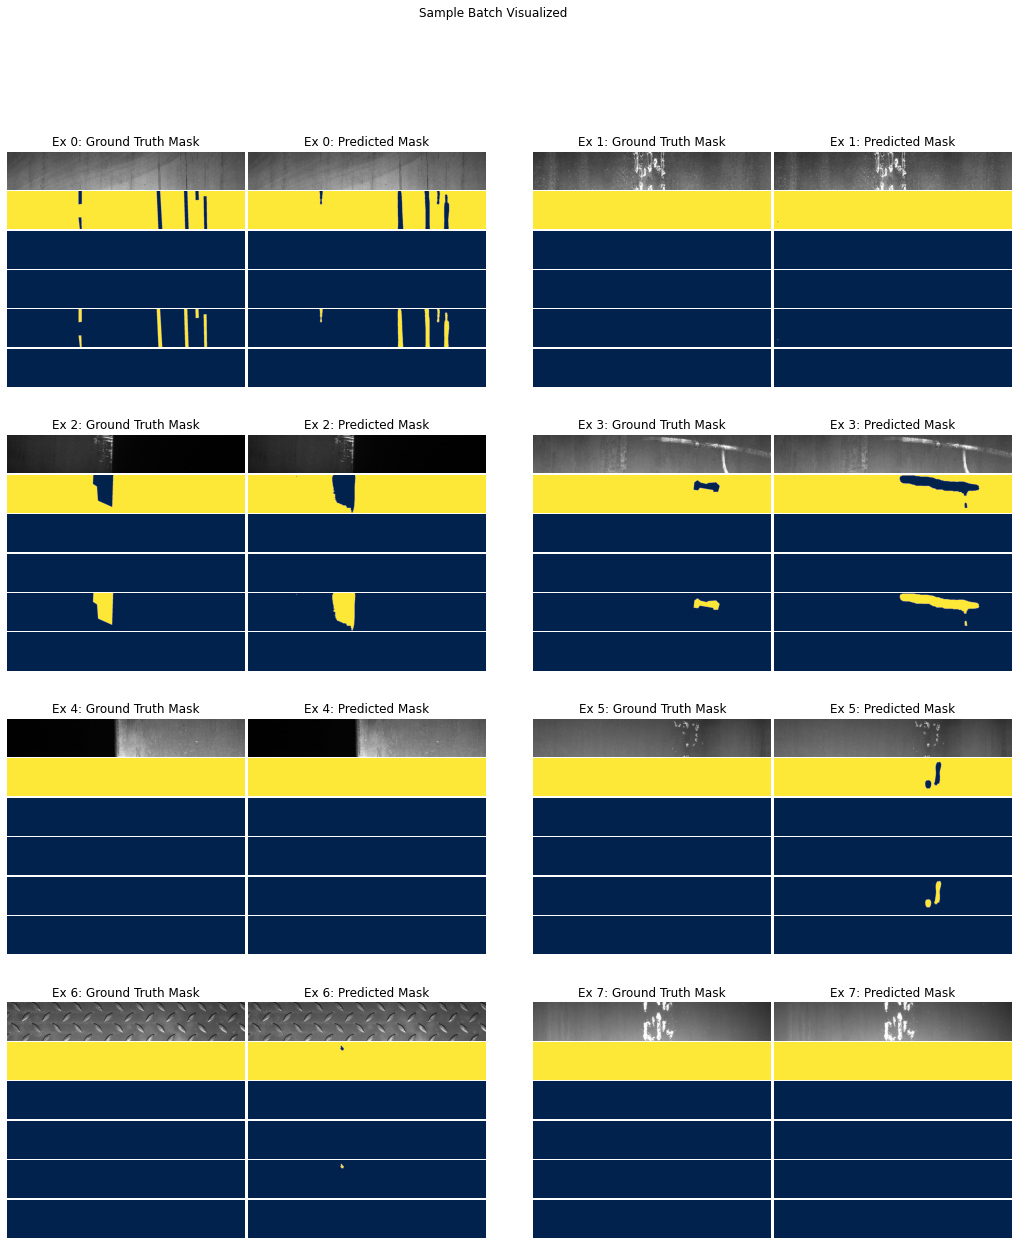

2022-10-21 16:16:53.484570: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 11s 11s/step


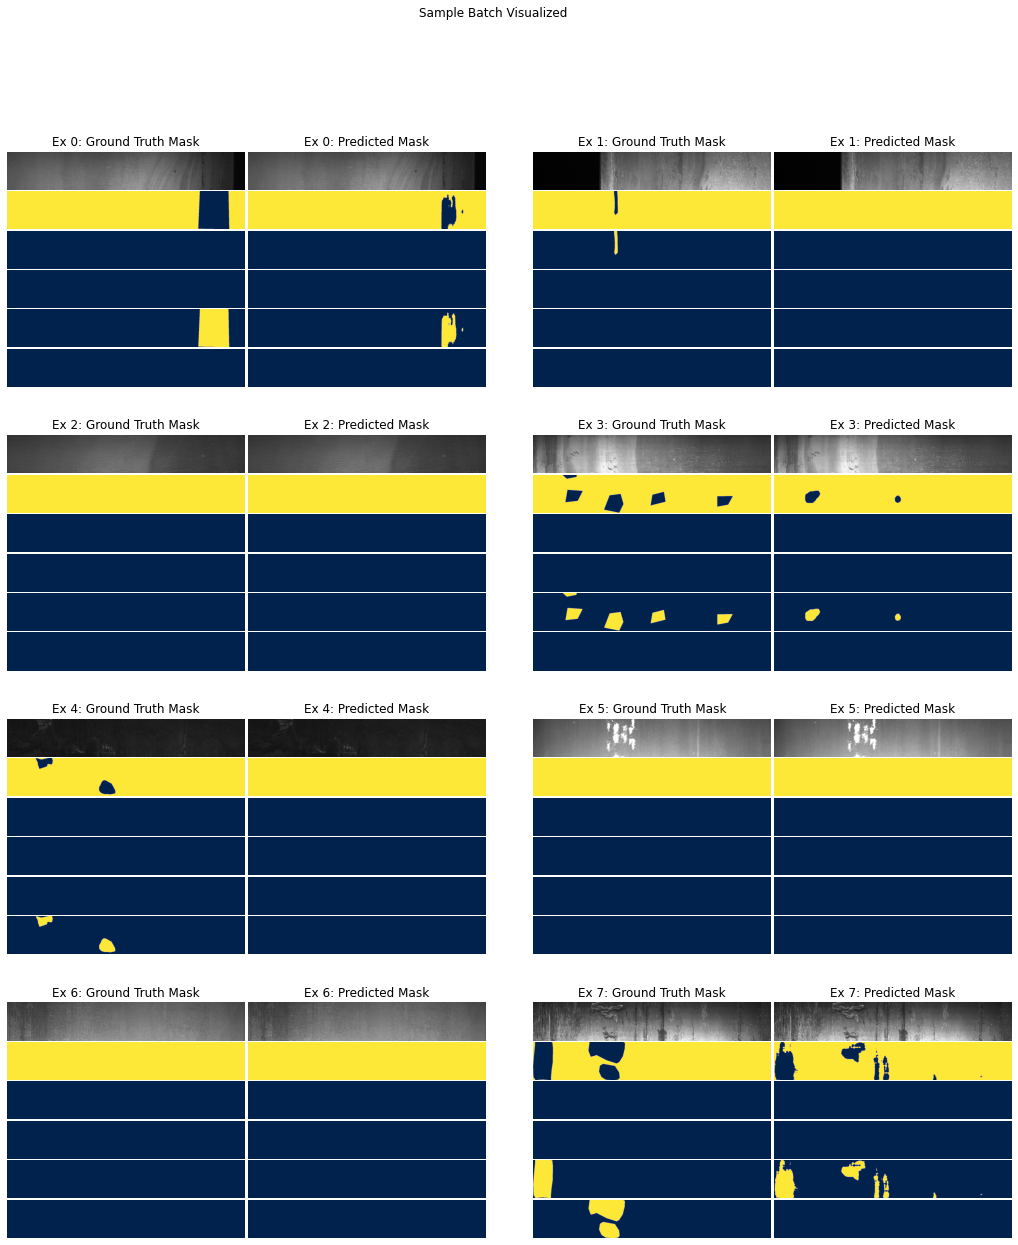

In [7]:
sample = list(test_dataset.take(4).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

    plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [4]:
class_scores = evaluate_per_class(test_dataset, unet_model, tversky_per_class)

  0%|          | 0/40 [00:00<?, ?it/s]2022-10-21 18:04:32.164353: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 14s 14s/step


  2%|▎         | 1/40 [00:15<10:11, 15.67s/it]2022-10-21 18:04:44.425893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 12s 12s/step


  5%|▌         | 2/40 [00:27<08:38, 13.65s/it]2022-10-21 18:04:56.378188: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 11s 11s/step


  8%|▊         | 3/40 [00:39<07:52, 12.77s/it]2022-10-21 18:05:08.276690: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 12s 12s/step


 10%|█         | 4/40 [00:51<07:30, 12.52s/it]2022-10-21 18:05:20.278038: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 11s 11s/step


 12%|█▎        | 5/40 [01:03<07:06, 12.17s/it]

1/1 [==============================] - 11s 11s/step


 15%|█▌        | 6/40 [01:14<06:47, 11.97s/it]

1/1 [==============================] - 11s 11s/step


 18%|█▊        | 7/40 [01:26<06:28, 11.79s/it]

1/1 [==============================] - 11s 11s/step


 20%|██        | 8/40 [01:37<06:11, 11.61s/it]

1/1 [==============================] - 11s 11s/step


 22%|██▎       | 9/40 [01:48<05:57, 11.54s/it]

1/1 [==============================] - 11s 11s/step


 25%|██▌       | 10/40 [02:00<05:49, 11.66s/it]

1/1 [==============================] - 12s 12s/step


 28%|██▊       | 11/40 [02:13<05:43, 11.83s/it]

1/1 [==============================] - 11s 11s/step


 30%|███       | 12/40 [02:24<05:31, 11.84s/it]

1/1 [==============================] - 11s 11s/step


 32%|███▎      | 13/40 [02:36<05:14, 11.66s/it]

1/1 [==============================] - 11s 11s/step


 35%|███▌      | 14/40 [02:47<05:02, 11.62s/it]

1/1 [==============================] - 11s 11s/step


 38%|███▊      | 15/40 [02:59<04:50, 11.62s/it]

1/1 [==============================] - 12s 12s/step


 40%|████      | 16/40 [03:11<04:42, 11.75s/it]

1/1 [==============================] - 11s 11s/step


 42%|████▎     | 17/40 [03:22<04:28, 11.66s/it]

1/1 [==============================] - 11s 11s/step


 45%|████▌     | 18/40 [03:34<04:17, 11.69s/it]

1/1 [==============================] - 11s 11s/step


 48%|████▊     | 19/40 [03:46<04:06, 11.74s/it]

1/1 [==============================] - 11s 11s/step


 50%|█████     | 20/40 [03:58<03:54, 11.72s/it]

1/1 [==============================] - 11s 11s/step


 52%|█████▎    | 21/40 [04:09<03:41, 11.67s/it]

1/1 [==============================] - 11s 11s/step


 55%|█████▌    | 22/40 [04:21<03:31, 11.76s/it]

1/1 [==============================] - 10s 10s/step


 57%|█████▊    | 23/40 [04:32<03:16, 11.55s/it]

1/1 [==============================] - 11s 11s/step


 60%|██████    | 24/40 [04:44<03:04, 11.53s/it]

1/1 [==============================] - 11s 11s/step


 62%|██████▎   | 25/40 [04:55<02:51, 11.46s/it]

1/1 [==============================] - 11s 11s/step


 65%|██████▌   | 26/40 [05:07<02:41, 11.55s/it]

1/1 [==============================] - 11s 11s/step


 68%|██████▊   | 27/40 [05:18<02:30, 11.54s/it]

1/1 [==============================] - 11s 11s/step


 70%|███████   | 28/40 [05:30<02:18, 11.54s/it]

1/1 [==============================] - 11s 11s/step


 72%|███████▎  | 29/40 [05:41<02:05, 11.41s/it]

1/1 [==============================] - 11s 11s/step


 75%|███████▌  | 30/40 [05:52<01:53, 11.35s/it]

1/1 [==============================] - 11s 11s/step


 78%|███████▊  | 31/40 [06:03<01:42, 11.35s/it]

1/1 [==============================] - 11s 11s/step


 80%|████████  | 32/40 [06:15<01:31, 11.38s/it]

1/1 [==============================] - 11s 11s/step


 82%|████████▎ | 33/40 [06:26<01:20, 11.44s/it]

1/1 [==============================] - 11s 11s/step


 85%|████████▌ | 34/40 [06:39<01:09, 11.65s/it]

1/1 [==============================] - 12s 12s/step


 88%|████████▊ | 35/40 [06:51<00:59, 11.98s/it]

1/1 [==============================] - 11s 11s/step


 90%|█████████ | 36/40 [07:03<00:47, 11.89s/it]

1/1 [==============================] - 11s 11s/step


 92%|█████████▎| 37/40 [07:15<00:35, 11.80s/it]

1/1 [==============================] - 11s 11s/step


 95%|█████████▌| 38/40 [07:26<00:23, 11.63s/it]

1/1 [==============================] - 11s 11s/step


 98%|█████████▊| 39/40 [07:37<00:11, 11.47s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████| 40/40 [07:42<00:00, 11.56s/it]


In [5]:
class_scores

{0: 0.9884647, 1: 0.0014512812, 2: 0.0036353432, 3: 0.5724131, 4: 0.0014692384}

#### tversky_loss, no sample weighting

unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_False-strategy_ens-beta_0.999-small_sample_True-20221021-155208

In [51]:
MODEL_PATH = "../logs_sw_experiment/unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_False-strategy_ens-beta_0.999-small_sample_True-20221021-155208/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

2022-10-21 17:48:40.310851: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


1/1 [==============================] - 13s 13s/step


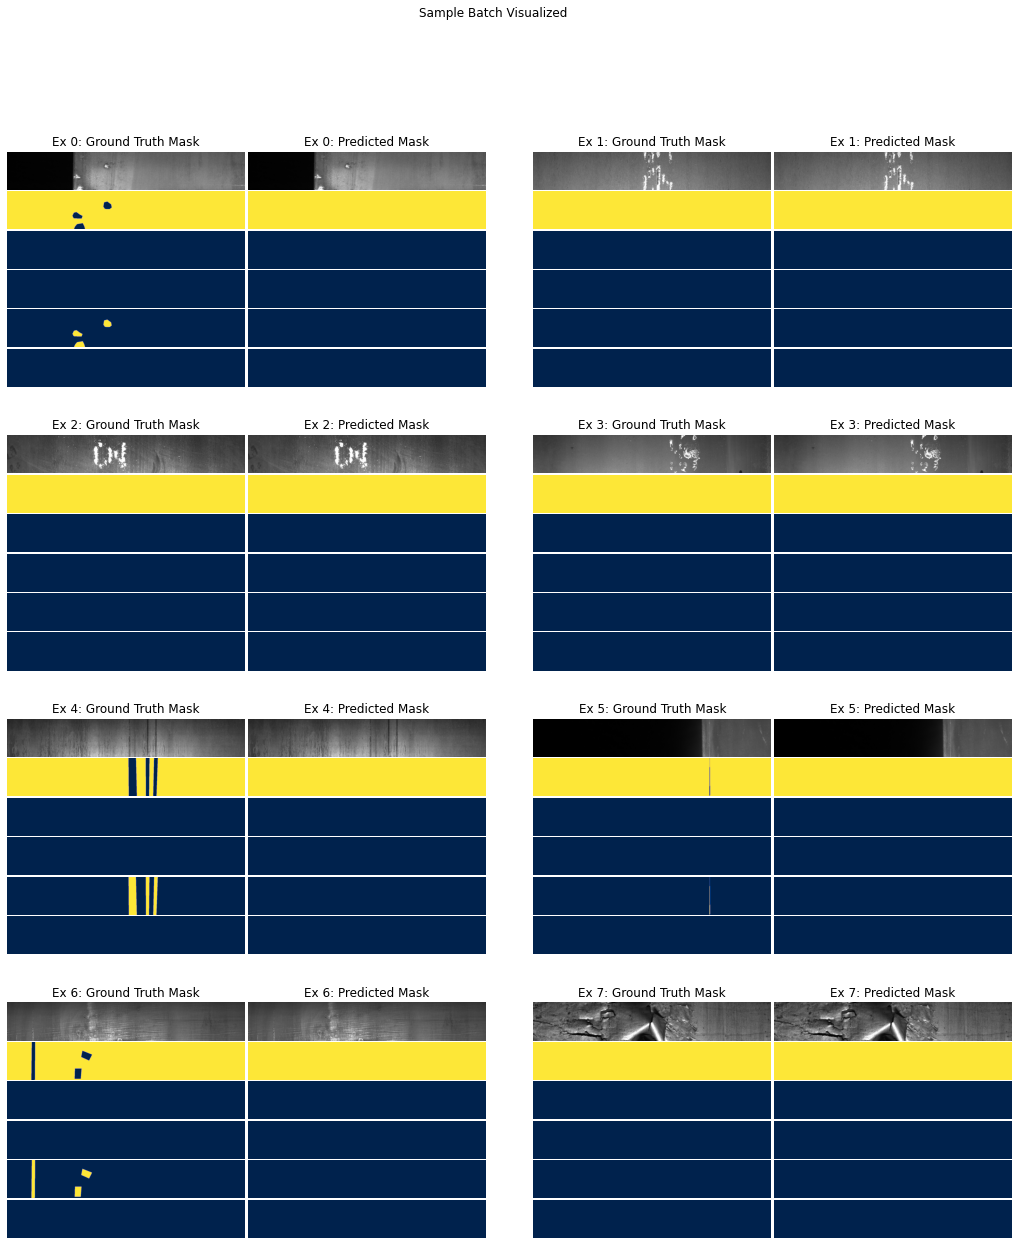

1/1 [==============================] - 11s 11s/step


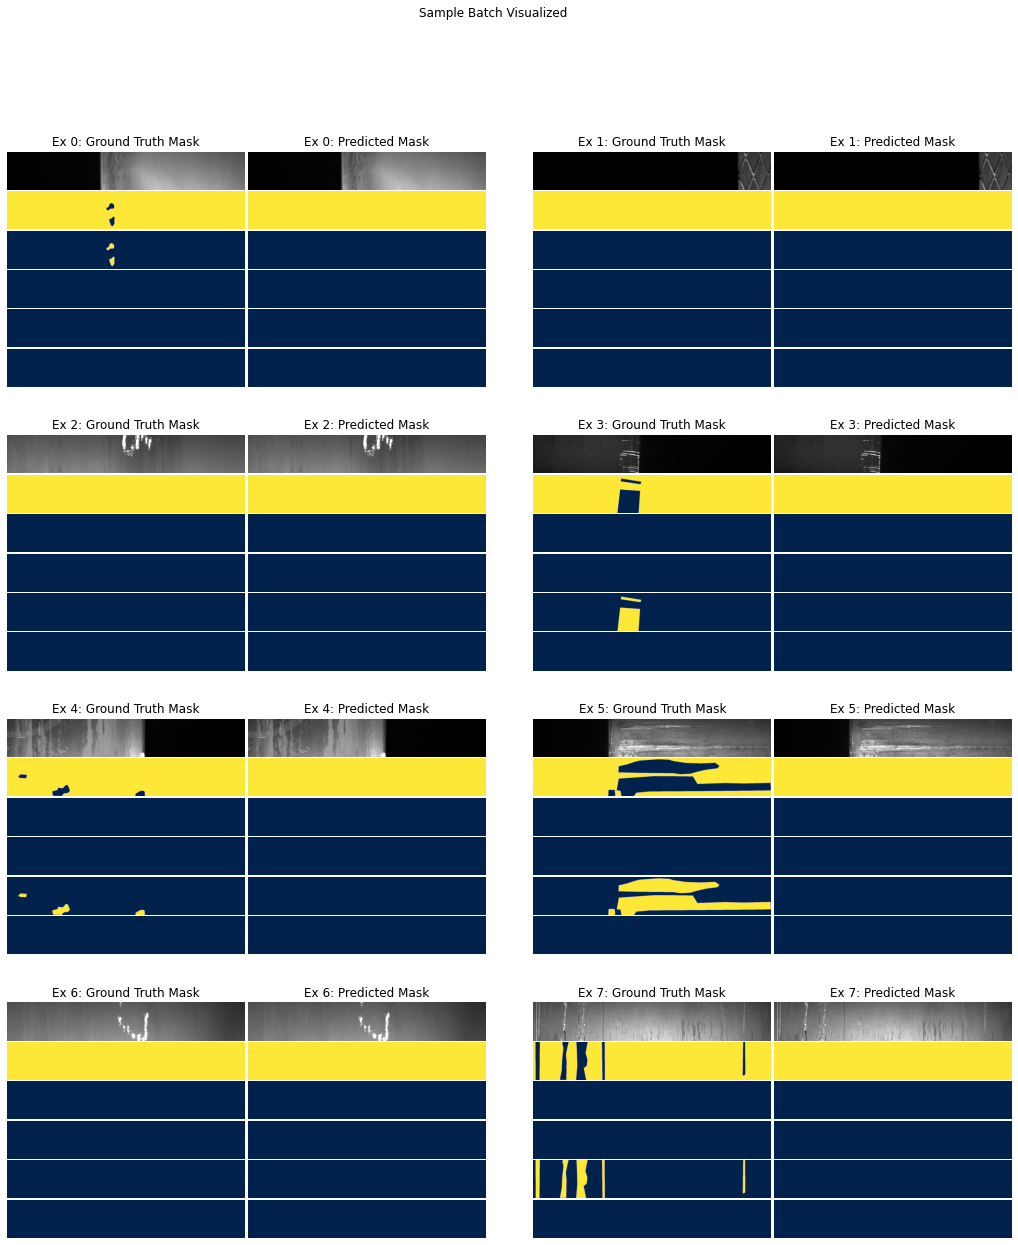

1/1 [==============================] - 12s 12s/step


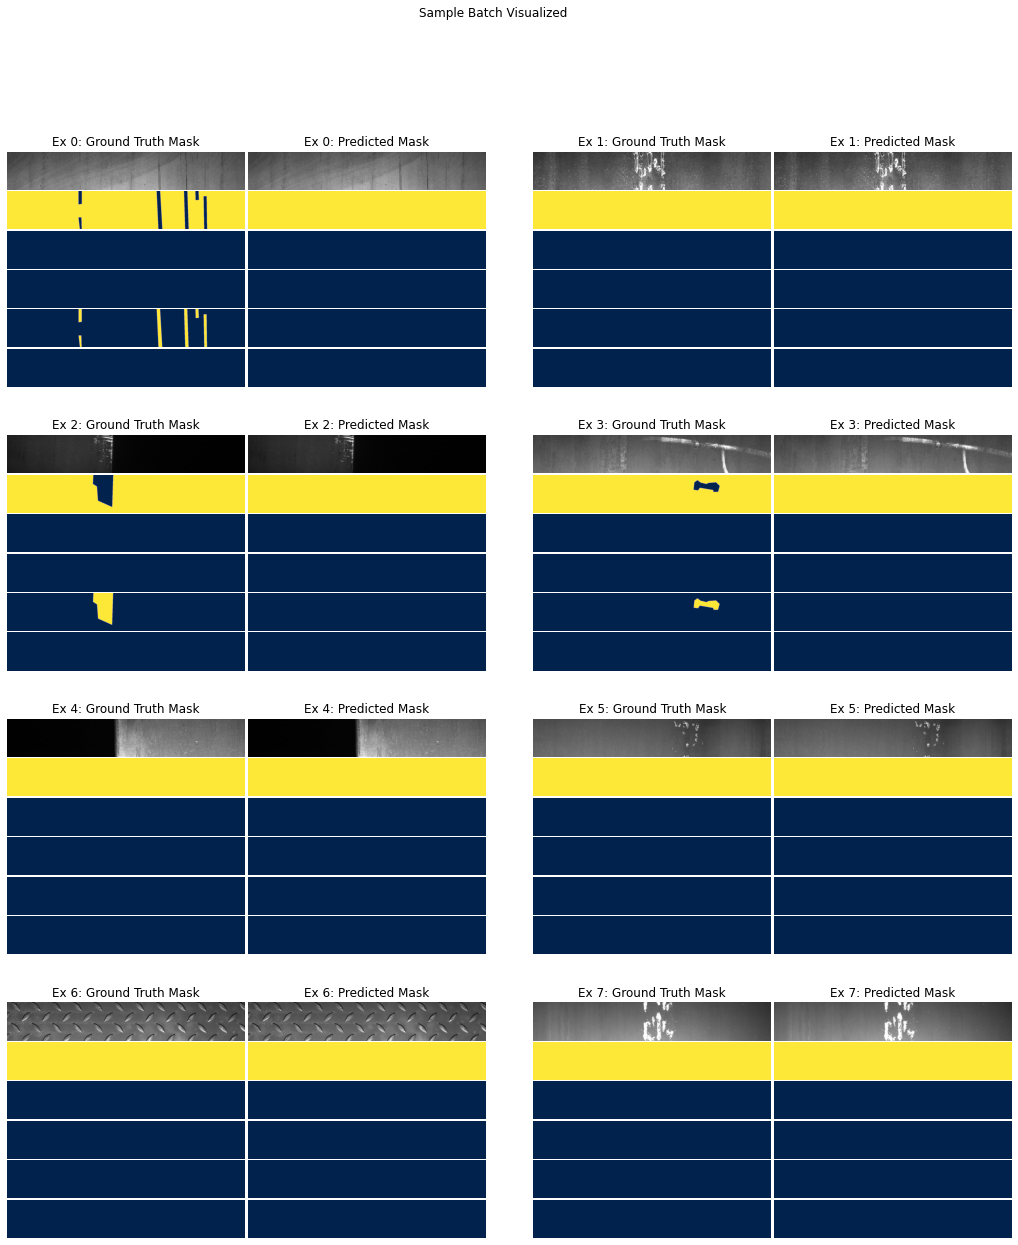

1/1 [==============================] - 11s 11s/step


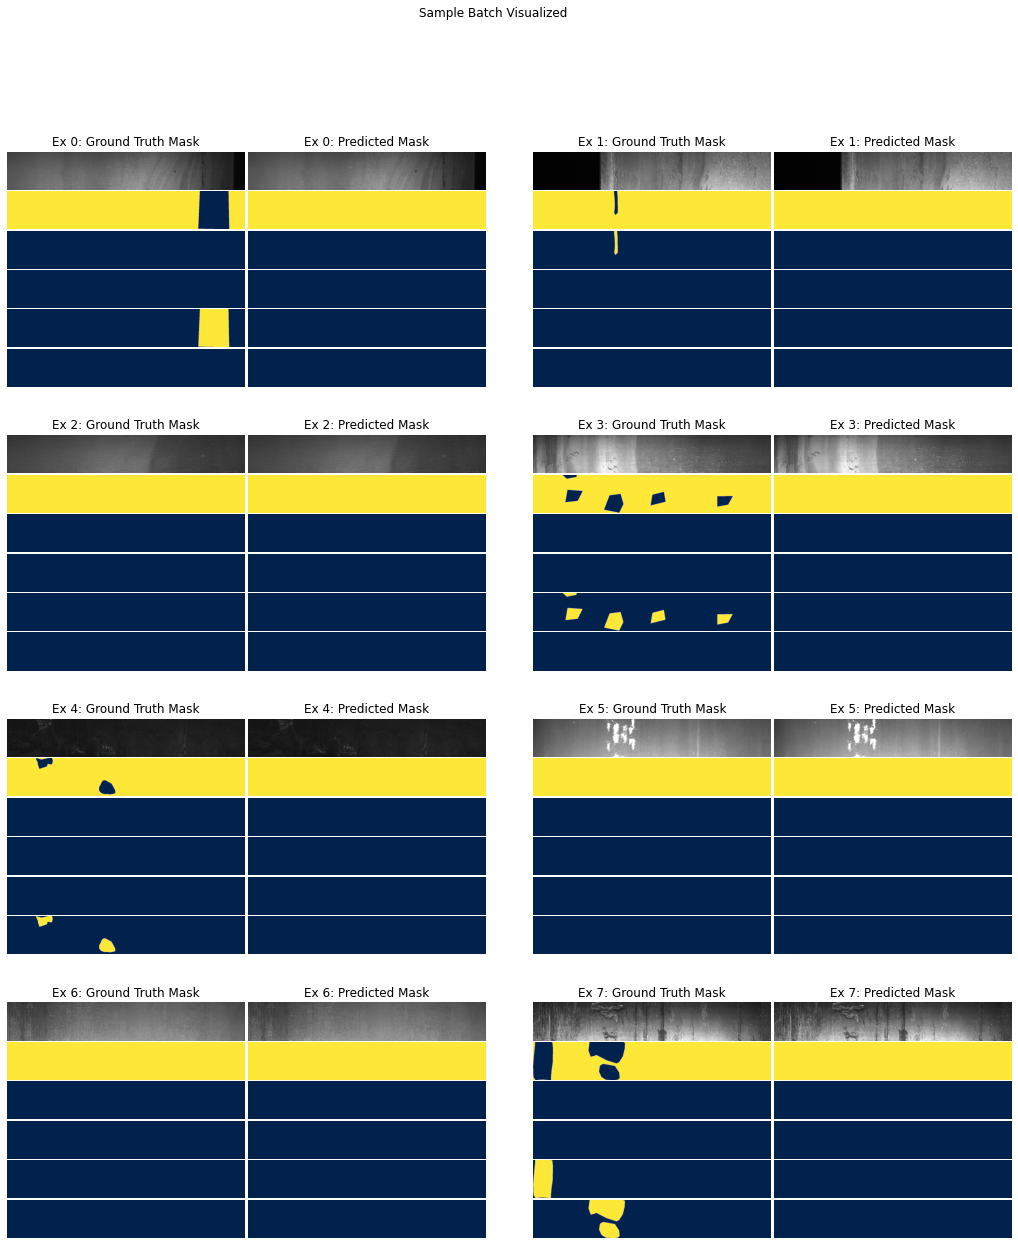

In [9]:
sample = list(test_dataset.take(4).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

    plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [7]:
class_scores = evaluate_per_class(test_dataset, unet_model, tversky_per_class)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 13s 13s/step


  2%|▎         | 1/40 [00:14<09:38, 14.82s/it]

1/1 [==============================] - 11s 11s/step


  5%|▌         | 2/40 [00:26<08:12, 12.97s/it]

1/1 [==============================] - 11s 11s/step


  8%|▊         | 3/40 [00:37<07:33, 12.26s/it]

1/1 [==============================] - 11s 11s/step


 10%|█         | 4/40 [00:49<07:06, 11.86s/it]

1/1 [==============================] - 11s 11s/step


 12%|█▎        | 5/40 [01:00<06:52, 11.78s/it]

1/1 [==============================] - 11s 11s/step


 15%|█▌        | 6/40 [01:12<06:34, 11.61s/it]

1/1 [==============================] - 11s 11s/step


 18%|█▊        | 7/40 [01:23<06:19, 11.51s/it]

1/1 [==============================] - 11s 11s/step


 20%|██        | 8/40 [01:34<06:05, 11.42s/it]

1/1 [==============================] - 11s 11s/step


 22%|██▎       | 9/40 [01:46<05:59, 11.60s/it]

1/1 [==============================] - 12s 12s/step


 25%|██▌       | 10/40 [01:58<05:52, 11.77s/it]

1/1 [==============================] - 11s 11s/step


 28%|██▊       | 11/40 [02:10<05:40, 11.75s/it]

1/1 [==============================] - 11s 11s/step


 30%|███       | 12/40 [02:21<05:26, 11.66s/it]

1/1 [==============================] - 11s 11s/step


 32%|███▎      | 13/40 [02:33<05:14, 11.66s/it]

1/1 [==============================] - 11s 11s/step


 35%|███▌      | 14/40 [02:44<05:00, 11.56s/it]

1/1 [==============================] - 11s 11s/step


 38%|███▊      | 15/40 [02:56<04:50, 11.62s/it]

1/1 [==============================] - 12s 12s/step


 40%|████      | 16/40 [03:09<04:45, 11.89s/it]

1/1 [==============================] - 11s 11s/step


 42%|████▎     | 17/40 [03:20<04:31, 11.83s/it]

1/1 [==============================] - 11s 11s/step


 45%|████▌     | 18/40 [03:32<04:19, 11.81s/it]

1/1 [==============================] - 11s 11s/step


 48%|████▊     | 19/40 [03:44<04:07, 11.76s/it]

1/1 [==============================] - 11s 11s/step


 50%|█████     | 20/40 [03:55<03:53, 11.70s/it]

1/1 [==============================] - 11s 11s/step


 52%|█████▎    | 21/40 [04:07<03:43, 11.75s/it]

1/1 [==============================] - 11s 11s/step


 55%|█████▌    | 22/40 [04:19<03:31, 11.76s/it]

1/1 [==============================] - 10s 10s/step


 57%|█████▊    | 23/40 [04:30<03:16, 11.54s/it]

1/1 [==============================] - 11s 11s/step


 60%|██████    | 24/40 [04:42<03:05, 11.60s/it]

1/1 [==============================] - 11s 11s/step


 62%|██████▎   | 25/40 [04:54<02:55, 11.72s/it]

1/1 [==============================] - 11s 11s/step


 65%|██████▌   | 26/40 [05:06<02:44, 11.75s/it]

1/1 [==============================] - 11s 11s/step


 68%|██████▊   | 27/40 [05:17<02:31, 11.65s/it]

1/1 [==============================] - 11s 11s/step


 70%|███████   | 28/40 [05:29<02:20, 11.71s/it]

1/1 [==============================] - 11s 11s/step


 72%|███████▎  | 29/40 [05:41<02:08, 11.70s/it]

1/1 [==============================] - 11s 11s/step


 75%|███████▌  | 30/40 [05:52<01:55, 11.60s/it]

1/1 [==============================] - 11s 11s/step


 78%|███████▊  | 31/40 [06:03<01:44, 11.59s/it]

1/1 [==============================] - 11s 11s/step


 80%|████████  | 32/40 [06:15<01:33, 11.67s/it]

1/1 [==============================] - 11s 11s/step


 82%|████████▎ | 33/40 [06:27<01:21, 11.66s/it]

1/1 [==============================] - 11s 11s/step


 85%|████████▌ | 34/40 [06:39<01:10, 11.76s/it]

1/1 [==============================] - 11s 11s/step


 88%|████████▊ | 35/40 [06:50<00:58, 11.61s/it]

1/1 [==============================] - 11s 11s/step


 90%|█████████ | 36/40 [07:02<00:46, 11.63s/it]

1/1 [==============================] - 11s 11s/step


 92%|█████████▎| 37/40 [07:14<00:35, 11.67s/it]

1/1 [==============================] - 11s 11s/step


 95%|█████████▌| 38/40 [07:25<00:23, 11.59s/it]

1/1 [==============================] - 11s 11s/step


 98%|█████████▊| 39/40 [07:37<00:11, 11.60s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████| 40/40 [07:42<00:00, 11.55s/it]


In [8]:
class_scores

{0: 0.99164075, 1: 0.525, 2: 0.9, 3: 0.05, 4: 0.625}

In [52]:
sample = list(test_dataset.take(1).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

1/1 [==============================] - 13s 13s/step


In [11]:
y_true.shape, y_pred.shape

((8, 256, 1600, 5), (8, 256, 1600, 5))

In [12]:
y_true

array([[[[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]],

        ...,

        [[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         

In [13]:
y_pred

array([[[[9.99999940e-01, 8.94911278e-31, 1.24801354e-31,
          4.80444172e-32, 5.89446000e-31],
         [9.99999940e-01, 1.26032671e-26, 2.39061139e-27,
          4.24308463e-28, 1.12373637e-26],
         [9.99999940e-01, 2.26595095e-27, 4.01690414e-28,
          7.16765283e-29, 1.97895523e-27],
         ...,
         [9.99999940e-01, 4.15740267e-26, 7.99347979e-27,
          1.00984567e-27, 3.92670183e-26],
         [9.99999940e-01, 6.32744408e-26, 1.23207093e-26,
          1.57196935e-27, 6.06710334e-26],
         [9.99999940e-01, 6.04182430e-30, 8.68543153e-31,
          1.74616524e-31, 4.68960819e-30]],

        [[9.99999940e-01, 5.22272479e-29, 6.31031699e-30,
          6.02467515e-31, 4.64717326e-29],
         [9.99999940e-01, 2.57194830e-23, 4.37447827e-24,
          1.72794829e-25, 3.15285206e-23],
         [9.99999940e-01, 1.30238046e-24, 2.02258192e-25,
          7.94311287e-27, 1.57566407e-24],
         ...,
         [9.99999940e-01, 1.78094626e-22, 2.77713307e-23,
   

In [24]:
true_pos.shape

TensorShape([8])

In [14]:
tversky_axis(y_true, y_pred)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([2.3484653e-10, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       5.6906133e-11, 1.9124118e-09, 1.2543432e-10, 1.0000000e+00],
      dtype=float32)>

In [16]:
tf.reduce_sum(tversky_axis(y_true, y_pred)) / 8

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [18]:
(0 + 1 + 1 + 1 + 0 + 0 + 0 + 1) / 8

0.5

In [15]:
tversky(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=7.6941425e-11>

In [61]:
# ground truth mask
# set first channel as background, 2 pixel defect
y_true = np.zeros((2, 4, 4, 3))
y_true[0, (1, 2), 1, 1] = 1.0
y_true[0, :, :, 0], y_true[0, :, :, 1], y_true[0, :, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [62]:
# pred_mask
# set first channel as background, 2 pixel defect
y_pred = np.zeros((2, 4, 4, 3))
y_pred[0, 1, (1, 2), 1] = 1.0
y_pred[0, :, :, 0], y_pred[0, :, :, 1], y_pred[0, :, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [69]:
y_true.shape

(2, 4, 4, 3)

In [72]:
y_true_test = y_true[0, ...]
y_pred_test = y_pred[0, ...]

In [74]:
y_true_test[:, :, 0], y_true_test[:, :, 1], y_true_test[:, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [75]:
y_pred_test[:, :, 0], y_pred_test[:, :, 1], y_pred_test[:, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [79]:
true_pos = y_true_test * y_pred_test
false_neg = y_true_test * (1 - y_pred_test)
false_pos = (1 - y_true_test) * y_pred_test

In [77]:
true_pos[:, :, 0], true_pos[:, :, 1], true_pos[:, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [80]:
false_neg[:, :, 0], false_neg[:, :, 1], false_neg[:, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [81]:
false_pos[:, :, 0], false_pos[:, :, 1], false_pos[:, :, 2]

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [36]:
tversky_axis(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.50000025, 1.        ])>

In [37]:
tf.reduce_sum(tversky_axis(y_true, y_pred)) / 2

<tf.Tensor: shape=(), dtype=float64, numpy=0.7500001249999375>

In [38]:
tversky(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.50000024>

In [43]:
num_t, den_t = tversky(y_true, y_pred)
num_t, den_t

(<tf.Tensor: shape=(), dtype=float32, numpy=1.000001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.000001>)

In [41]:
num_ta, den_ta = tversky_axis(y_true, y_pred)
num_ta, den_ta

(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.000001e+00, 1.000000e-06])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.000001e+00, 1.000000e-06])>)

In [84]:
1.00001 / 2.00001

0.5000024999875001

In [66]:
(0.5 + 1) / 2

0.75

In [67]:
2 / 4

0.5

In [82]:
0 + 0.5 / 2

0.25

In [83]:
1 + 0.5 / 2

1.25

** need to: reduce_sum(num)/reduce_sum(den)**

In [49]:
num_ta, den_ta = tversky_axis(y_true, y_pred)
num_ta, den_ta

(<tf.Tensor: shape=(), dtype=float64, numpy=1.000001>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.000001>)

In [50]:
num_ta / den_ta

<tf.Tensor: shape=(), dtype=float64, numpy=0.5000002499998749>

In [65]:
tversky(y_true, y_pred), tversky_axis(y_true, y_pred), tf.reduce_sum(
    tversky_axis(y_true, y_pred)
) / 2

(<tf.Tensor: shape=(), dtype=float32, numpy=0.50000024>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.50000025, 1.        ])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.7500001249999375>)

In [64]:
def tversky_axis(y_true, y_pred, smooth=1e-6):
    # Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet

    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    axes = tuple(range(1, 4))  # compute over H x W x C, preserve batch dimension

    true_pos = tf.reduce_sum(y_true * y_pred, axis=axes)
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=axes)
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=axes)
    alpha = 0.7

    # num = true_pos
    # den = true_pos + alpha * false_neg + (1 - alpha) * false_pos

    # return (
    #     tf.reduce_sum(num) + smooth / tf.reduce_sum(den) + smooth
    # )
    # return num + smooth / den + smooth

    num = true_pos + smooth
    den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

    return num / den


def tversky(y_true, y_pred, smooth=1e-6):
    # Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet

    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7

    num = true_pos + smooth
    den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

    return num / den

#### Plot by class

Takes:
 - model
 - class
 - test vs train
 - n_examples


In [7]:
def get_sample_by_class(class_idx, dataset, pipeline, model):

    class_imgs = dataset.imgid_to_classid_mapping[
        dataset.imgid_to_classid_mapping == class_idx
    ].index.tolist()

    X = dataset.get_image_sequence(class_imgs)
    y = dataset.get_label_sequence(class_imgs, label_type="preprocessed")

    ds = pipeline(X, y, is_train=False)

    sample = list(ds.take(1).as_numpy_iterator())

    for batch in sample:
        x = batch[0]
        y_true = batch[1]
        y_pred = model.predict(x)

    return x, y_true, y_pred

In [3]:
def plot_samples_by_class(class_idx, dataset, pipeline, model, n_batches):

    class_imgs = dataset.imgid_to_classid_mapping[
        dataset.imgid_to_classid_mapping == class_idx
    ].index.tolist()

    X = dataset.get_image_sequence(class_imgs)
    y = dataset.get_label_sequence(class_imgs, label_type="preprocessed")

    ds = pipeline(X, y, is_train=False)

    sample = list(ds.take(n_batches).as_numpy_iterator())

    for batch in sample:
        x = batch[0]
        y_true = batch[1]
        y_pred = model.predict(x)

        plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [5]:
MODEL_PATH = "../logs_sw_experiment/unet-epochs_50-lr_0.01-channels_512-loss_tversky_loss_axis-sw_True-strategy_ens-beta_0.999-small_sample_False-20221021-020701/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

In [9]:
x, y_true, y_pred = get_sample_by_class(
    class_idx=2, dataset=sd, pipeline=sdp, model=unet_model
)

Batching
1/1 [==============================] - 15s 15s/step


In [13]:
tversky_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [14]:
tversky_loss_axis(y_true, y_pred)

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [15]:
tversky_per_class(y_true, y_pred)

{0: 0.9976071, 1: 1.0, 2: 5.4964082e-11, 3: 1.0, 4: 1.0}

In [16]:
{k: 1 - v for k, v in tversky_per_class(y_true, y_pred).items()}

{0: 0.002392888069152832, 1: 0.0, 2: 0.999999999945036, 3: 0.0, 4: 0.0}

Batching
1/1 [==============================] - 12s 12s/step


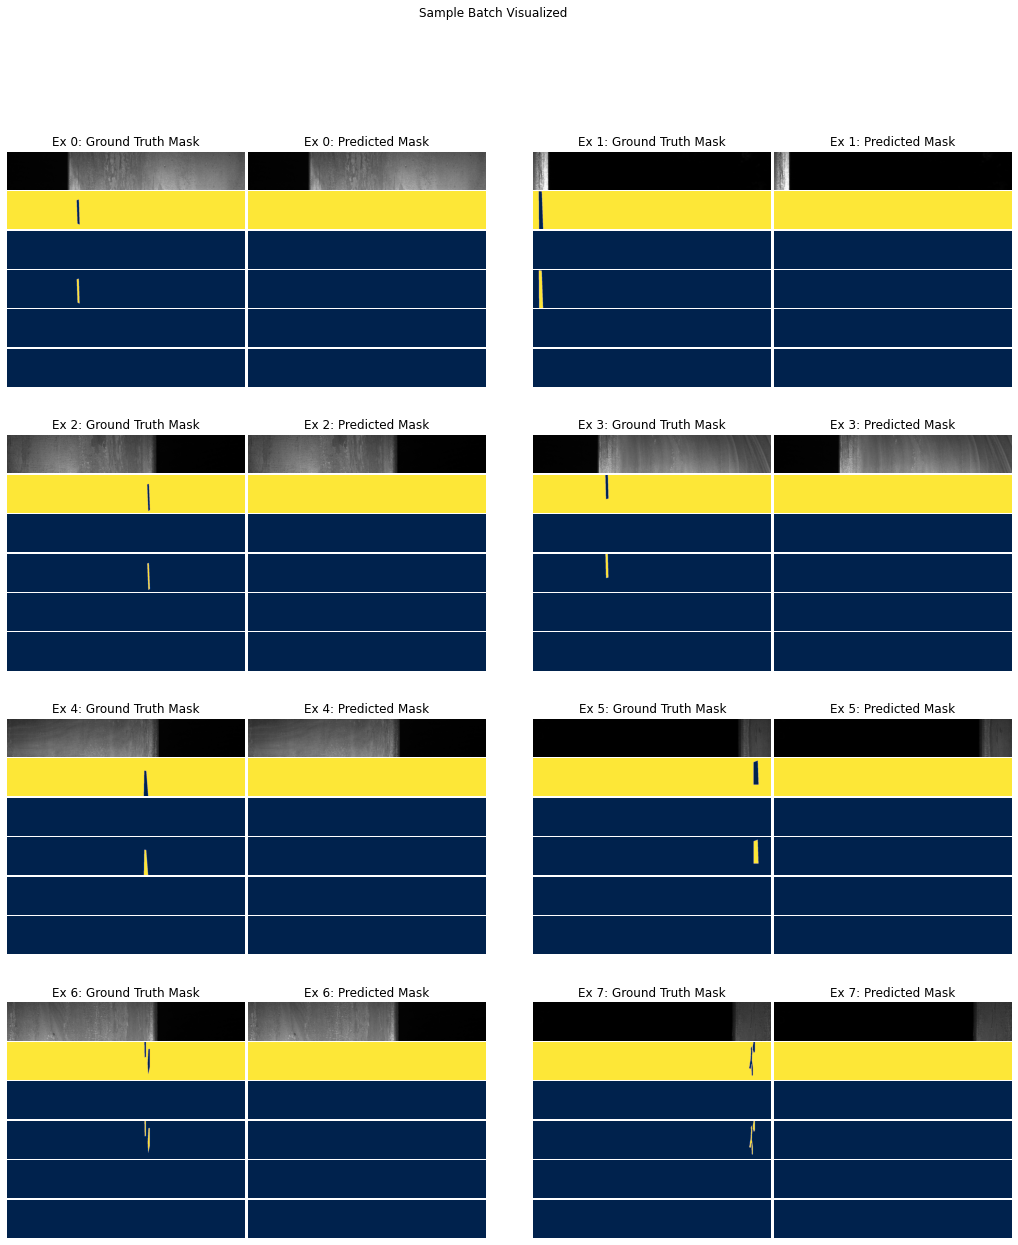

1/1 [==============================] - 11s 11s/step


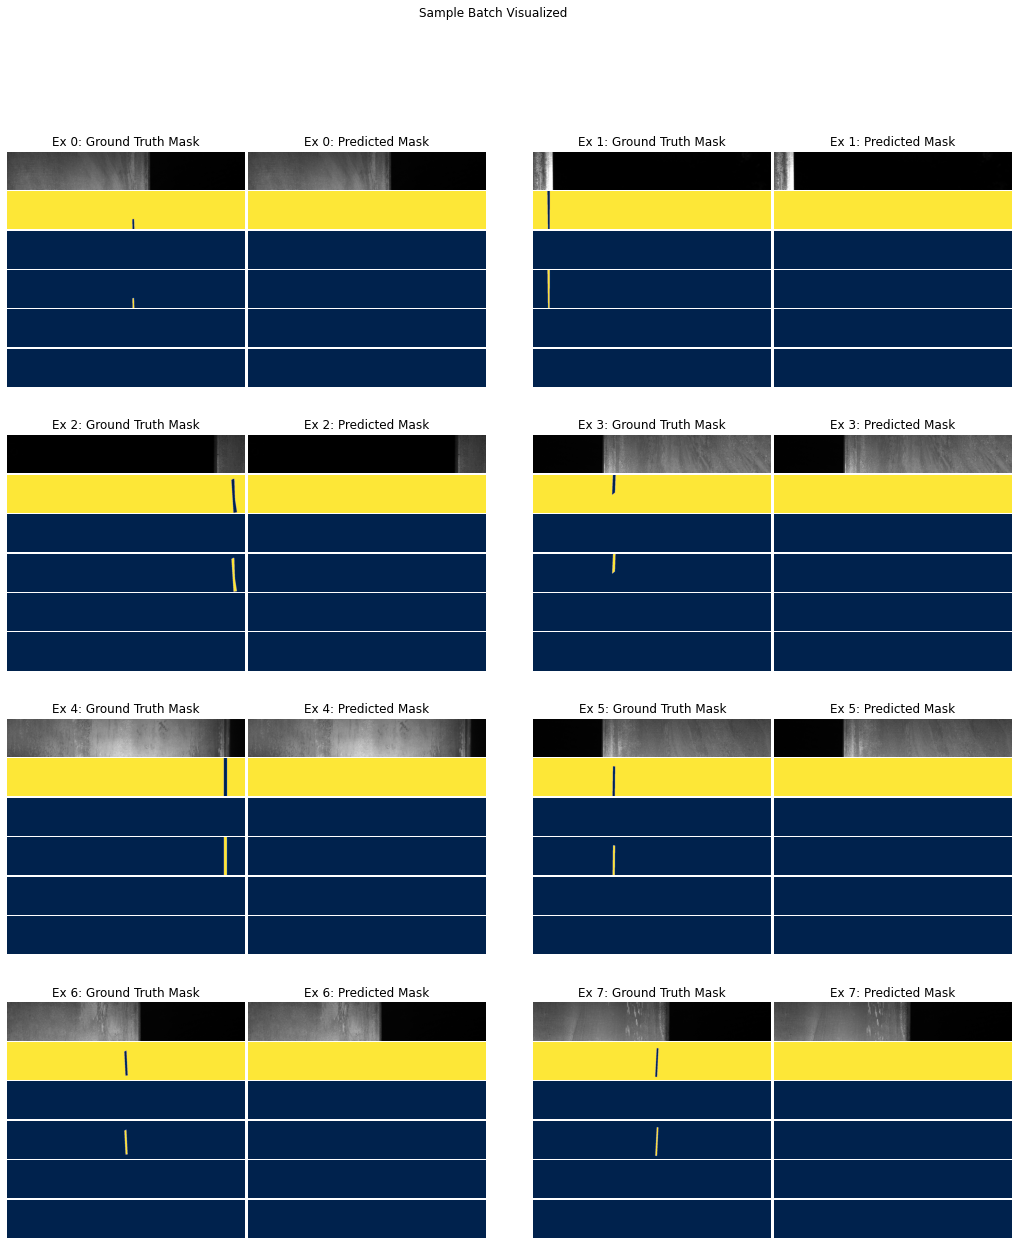

1/1 [==============================] - 11s 11s/step


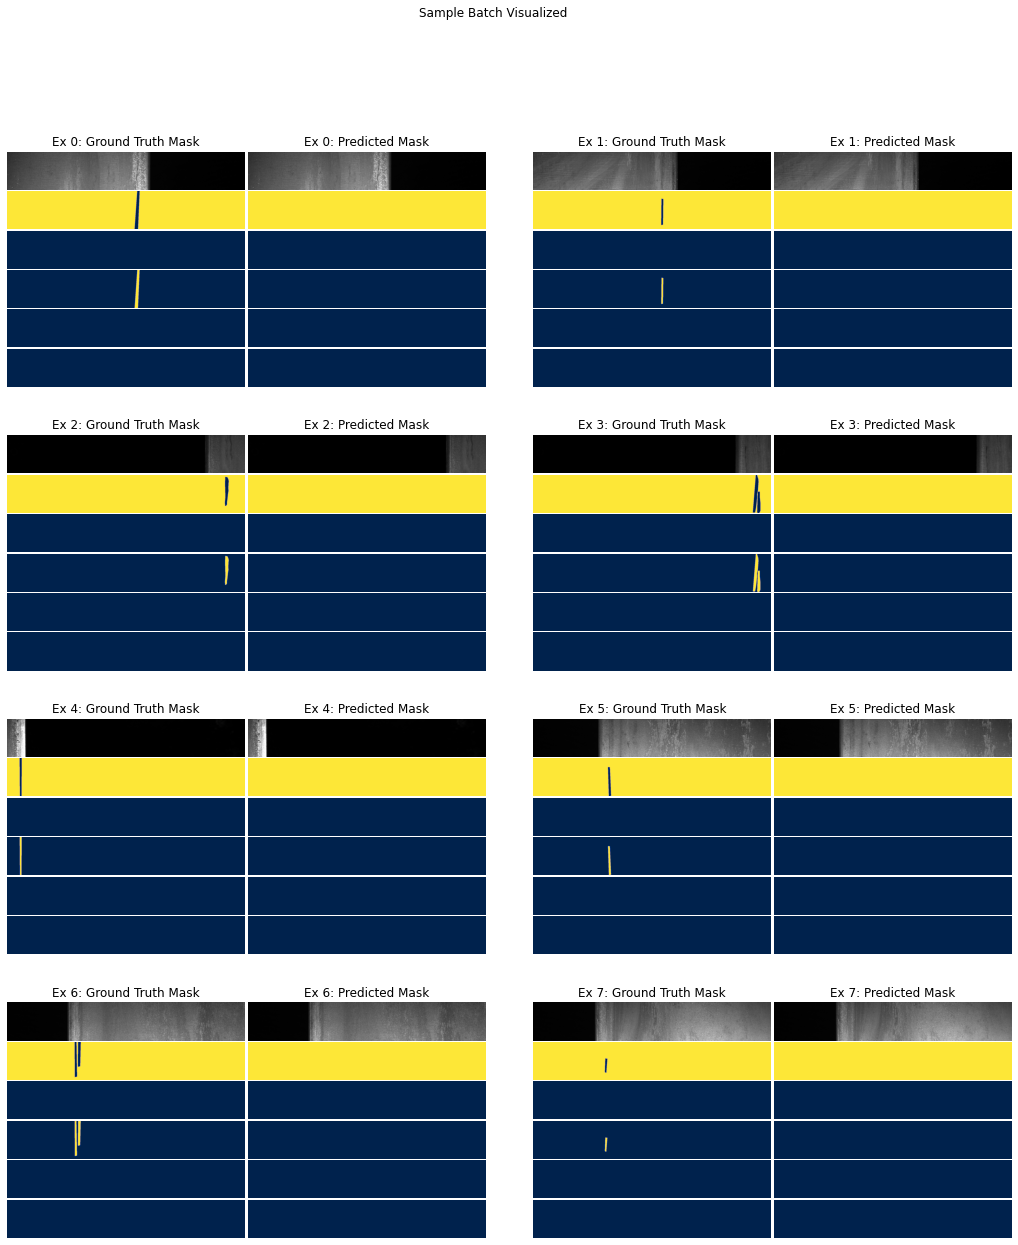

1/1 [==============================] - 11s 11s/step


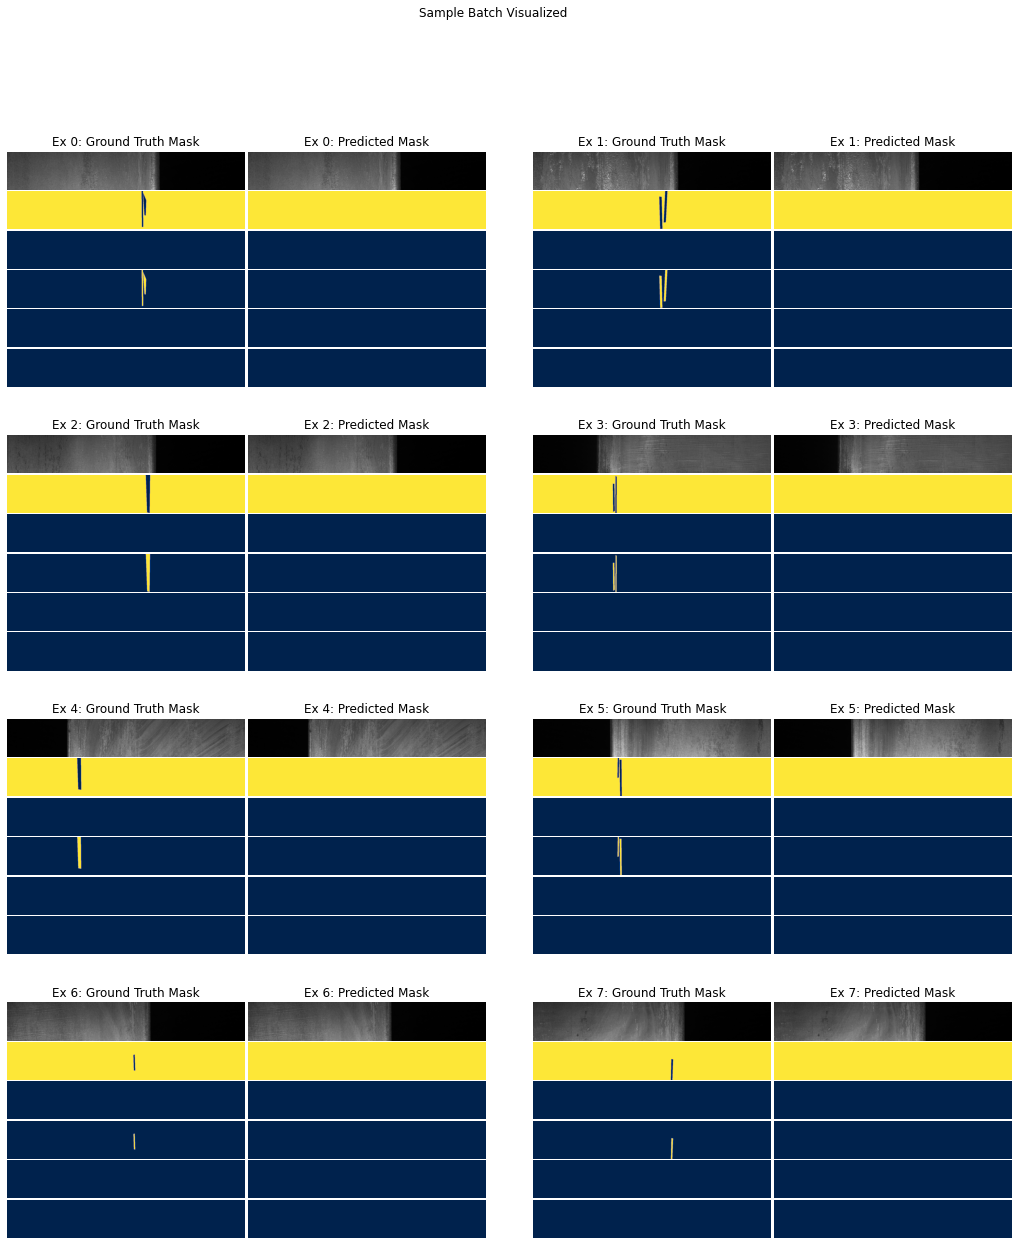

In [17]:
plot_samples_by_class(
    class_idx=2, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4
)

In [27]:
sd.imgid_to_classid_mapping[sd.imgid_to_classid_mapping == 1].index.tolist()

['0002cc93b.jpg',
 '000a4bcdd.jpg',
 '00bc01bfe.jpg',
 '01053d28f.jpg',
 '010db68d1.jpg',
 '012a9a4c7.jpg',
 '01661826d.jpg',
 '0167a740e.jpg',
 '017c828a1.jpg',
 '01df77e59.jpg',
 '02b2d3aa4.jpg',
 '02c4655ff.jpg',
 '036c4e5d2.jpg',
 '03da79fda.jpg',
 '0429258ad.jpg',
 '046c35525.jpg',
 '04e23e414.jpg',
 '056e34021.jpg',
 '059000a4f.jpg',
 '0603c2340.jpg',
 '06a01c775.jpg',
 '0728b2ac9.jpg',
 '077f0256d.jpg',
 '07ac7620c.jpg',
 '07ba66beb.jpg',
 '0829af407.jpg',
 '0832de752.jpg',
 '08808b1a2.jpg',
 '08a8ed239.jpg',
 '0905fe055.jpg',
 '0934b8bff.jpg',
 '0999e53af.jpg',
 '09b428fe0.jpg',
 '0a4ad45a5.jpg',
 '0a8cb8ddf.jpg',
 '0aafd7471.jpg',
 '0b1a4d585.jpg',
 '0bb304645.jpg',
 '0bd6da716.jpg',
 '0c59df320.jpg',
 '0cf509103.jpg',
 '0d13c2a23.jpg',
 '0e7a45695.jpg',
 '0e86dea5b.jpg',
 '0e9356159.jpg',
 '0f1617841.jpg',
 '0f4bf08bd.jpg',
 '0f9a12222.jpg',
 '0f9f79a88.jpg',
 '0fb56c62d.jpg',
 '0fd63823c.jpg',
 '1017c52e8.jpg',
 '10d9f85be.jpg',
 '11418b1c5.jpg',
 '11f788ecf.jpg',
 '123b0882

## Class-balanced loss

In [49]:
sd.imgid_to_classid_mapping.value_counts().sort_index()

-2     427
-1    5902
 1     769
 2     195
 3    4759
 4     516
dtype: int64

In [3]:
classes = sd.imgid_to_classid_mapping.value_counts().sort_index().index.tolist()
samples_per_class = sd.imgid_to_classid_mapping.value_counts().sort_index().tolist()

In [4]:
classes, samples_per_class

([-2, -1, 1, 2, 3, 4], [427, 5902, 769, 195, 4759, 516])

In [7]:
den = 1 - np.power(0.99, samples_per_class)

In [8]:
num = 1 - 0.99

In [9]:
num / np.array(den)

array([0.01013874, 0.01      , 0.0100044 , 0.01163988, 0.01      ,
       0.01005626])

In [11]:
weights = num / np.array(den)

In [12]:
weights / np.sum(weights) * len(n)

array([0.16395312, 0.16170951, 0.16178069, 0.18822788, 0.16170951,
       0.16261928])

In [53]:
def class_balanced_weight_map(beta, samples_per_cls, num_classes, classes):
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * num_classes
    return weights

In [16]:
from src.model_utils import (
    calculate_class_weight_map_ip,
    calculate_class_weight_map_ens,
)

In [17]:
classes = sd.imgid_to_classid_mapping.value_counts().sort_index().index.tolist()
samples_per_class = sd.imgid_to_classid_mapping.value_counts().sort_index().tolist()

In [18]:
classes

[-2, -1, 1, 2, 3, 4]

In [ ]:
round()

In [24]:
calculate_class_weight_map_ip(
    classes=classes, imgid_to_classid_mapping=sd.imgid_to_classid_mapping
)

{-2: 4.9055, -1: 0.3549, 1: 2.7239, 2: 10.7419, 3: 0.4401, 4: 4.0594}

In [27]:
calculate_class_weight_map_ens(
    beta=0.999, samples_per_cls=samples_per_class, classes=classes
)

{-2: 1.1604, -1: 0.4045, 1: 0.7517, 2: 2.2761, 3: 0.4069, 4: 1.0004}

In [55]:
for beta in [0.9, 0.99, 0.999, 0.9999]:
    print(
        beta, " --- ", class_balanced_weight_map(beta, samples_per_class, len(classes))
    )

0.9  ---  [1. 1. 1. 1. 1. 1.]
0.99  ---  [0.98371873 0.97025706 0.97068417 1.12936731 0.97025706 0.97571569]
0.999  ---  [1.16035459 0.40452995 0.75167832 2.27609148 0.40690784 1.00043782]
0.9999  ---  [1.25925883 0.11808234 0.71116328 2.72581461 0.13900872 1.04667222]


In [ ]:
np.power()

In [13]:
sd.imgid_to_classid_mapping.unique()

array([ 1,  3,  4, -2,  2, -1])

In [15]:
type(sd.imgid_to_classid_mapping)

pandas.core.series.Series

## Per Class Evaluation

In [11]:
class_scores = evaluate_per_class_dice(test_dataset, unet_model)

1/1 [==============================] - 0s 88ms/step


: 

: 

In [12]:
y_true.shape

(8, 256, 1600, 5)

In [9]:
tversky_per_class(y_true, y_pred)

{0: (2900122.0, 2936246.0),
 1: (1e-06, 1.2776316e-05),
 2: (1e-06, 1.6575386e-05),
 3: (302947.94, 340554.2),
 4: (1e-06, 2.0591393e-05)}

In [23]:
y_pred[..., 1].shape

(8, 256, 1600)

In [27]:
for i in range(y_pred[..., 1].shape[0]):
    (y_pred[..., 1][i]).any()

In [10]:
smooth = 1e-6
class_idx = 1

y_true_class = y_true[..., class_idx]
y_pred_class = y_pred[..., class_idx]

y_true_pos = tf.keras.layers.Flatten()(y_true_class)
y_pred_pos = tf.keras.layers.Flatten()(y_pred_class)

true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
alpha = 0.7

num = true_pos + smooth
den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

score = num / den

In [17]:
tf.reduce_sum(y_true_pos)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [21]:
tf.reduce_sum((1 - y_true_pos))

<tf.Tensor: shape=(), dtype=float32, numpy=3276800.0>

In [22]:
tf.reduce_sum(y_pred_pos)

<tf.Tensor: shape=(), dtype=float32, numpy=3.9254384e-05>

In [12]:
false_neg

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [13]:
false_pos

<tf.Tensor: shape=(), dtype=float32, numpy=3.9254384e-05>

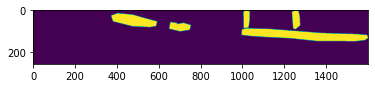

In [30]:
plt.imshow(y_true[2, :, :, 3])

In [ ]:
x=x, y_true=y_true, y_pred=y_pred

In [25]:
def tversky_per_class(y_true, y_pred, smooth=1e-6):

    metrics = {}

    for class_idx in range(y_true.shape[-1]):

        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]

        y_true_pos = tf.keras.layers.Flatten()(y_true_class)
        y_pred_pos = tf.keras.layers.Flatten()(y_pred_class)

        true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
        false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
        false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7

        num = true_pos + smooth
        den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

        score = num / den

        # metrics[class_idx] = score.numpy()
        metrics[class_idx] = num.numpy(), den.numpy()

    return metrics

In [26]:
from tqdm import tqdm
from typing import Optional, Dict
from collections import defaultdict


def evaluate_per_class(dataset: tf.data.Dataset, model, metric) -> Dict:
    """
    Evaluates a model on a given dataset to calculate _per class_ dice similarity coefficient.

    Args:
        dataset - tf dataset upon which to run evaluation
        model - trained UNet model to use for inference

    Returns:
        class_scores

    """

    class_scores = defaultdict(list)

    for x, y_true in tqdm(dataset):
        y_pred = model.predict(x)

        batch_score = metric(y_true, y_pred)

        for k, v in batch_score.items():
            class_scores[k].append(v)

    return {k: np.mean(v) for k, v in class_scores.items()}

In [20]:
device = cuda.get_current_device()
device.reset()

## Debug Loss Functions

In [25]:
sample = list(test_dataset.take(1).as_numpy_iterator())

x = sample[0][0]
y_true = sample[0][1]
y_pred = unet_model.predict(x)

x.shape, y_true.shape, y_pred.shape

1/1 [==============================] - 0s 77ms/step


((8, 256, 1600, 3), (8, 256, 1600, 5), (8, 256, 1600, 5))

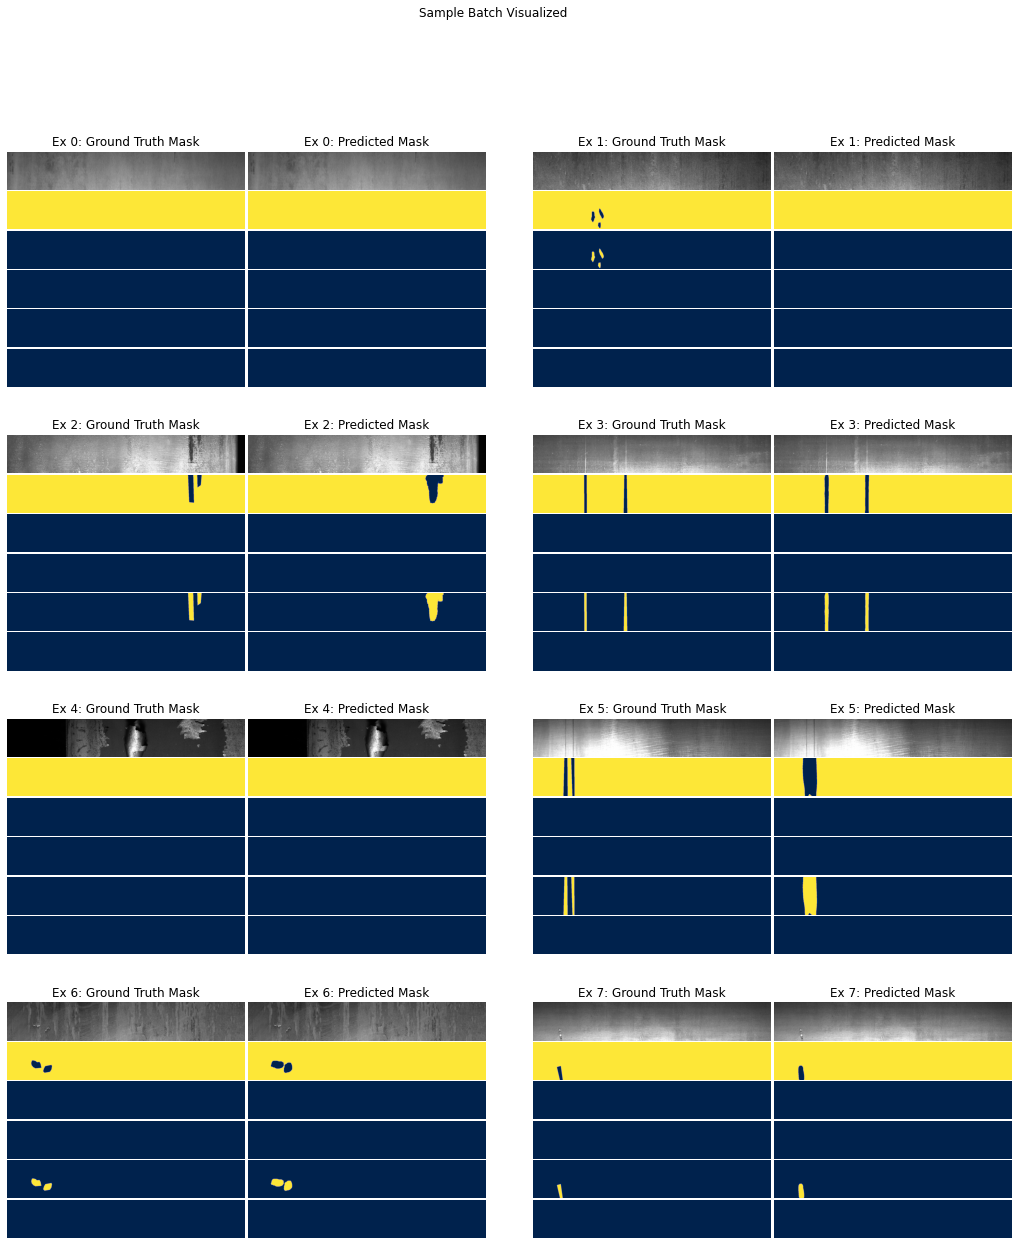

In [5]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [8]:
from src.model_utils import dice_coeff_old, dice_loss_old_class

In [9]:
dice_loss_old_class_ins = dice_loss_old_class()

In [6]:
dice_coeff(y_true, y_pred), dice_coeff_old(y_true, y_pred), dice_coeff_old_axis(
    y_true, y_pred
)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.7061437>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7061436>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([1.0000000e+00, 1.4722120e-09, 7.0978594e-01, 8.3217287e-01,
        1.0000000e+00, 6.3740933e-01, 7.9473907e-01, 7.7856678e-01],
       dtype=float32)>)

In [9]:
np.sum(dice_coeff_old_axis(y_true, y_pred)) / 8

0.7190842628479004

In [10]:
del unet_model

In [11]:
dice_loss_old_class_ins(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.28091574>

In [12]:
dice_loss_old_class_ins.reduction

'auto'

In [80]:
dice_coeff(y_true, y_pred), dice_coeff_old(y_true, y_pred)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.7061437>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([1.0000000e+00, 1.4722120e-09, 7.0978594e-01, 8.3217287e-01,
        1.0000000e+00, 6.3740933e-01, 7.9473907e-01, 7.7856678e-01],
       dtype=float32)>)

#### Ex 5

In [86]:
def tversky_axis(y_true, y_pred, smooth=1e-6):
    # Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet

    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    axes = tuple(range(1, 4)) # compute over H x W x C, preserve batch dimension

    true_pos = tf.reduce_sum(y_true * y_pred, axis=axes)
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=axes)
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=axes)
    alpha = 0.7

    num = true_pos + smooth
    den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

    return num / den


def tversky(y_true, y_pred, smooth=1e-6):
    # Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet

    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7

    num = true_pos + smooth
    den = true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth

    return num / den


def dice_coeff(y_true, y_pred, smooth=1e-6):

    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

    num = 2.0 * intersection + smooth
    den = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth

    # return num, den
    return score


def dice_coeff_old(y_true, y_pred, epsilon=1e-6):
    """
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.

    Args:
        y_true: b x X x Y x c One hot encoding of ground truth
        y_pred: b x X x Y x c Network output, must sum to 1 over c channel (such as after softmax)
        epsilon: Used for numerical stability to avoid divide by zero errors
    """
    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    axes = tuple(range(1, 3))
    numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)
    # denominator = tf.reduce_sum(y_pred + y_true, axis=axes)
    denominator = tf.reduce_sum(y_pred, axis=axes) + tf.reduce_sum(y_true, axis=axes)
    # denominator = tf.reduce_sum(y_true + y_pred, axis=axes)

    # return tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))
    # return numerator, denominator
    return tf.reduce_mean(numerator + epsilon) / tf.reduce_mean(
        denominator + epsilon
    )  # CORRECTED


def dice_coeff_old_axis(y_true, y_pred, epsilon=1e-6):
    """
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.

    Args:
        y_true: b x X x Y x c One hot encoding of ground truth
        y_pred: b x X x Y x c Network output, must sum to 1 over c channel (such as after softmax)
        epsilon: Used for numerical stability to avoid divide by zero errors
    """
    # remove background channel from loss calculation
    y_true = y_true[:, :, :, 1:]
    y_pred = y_pred[:, :, :, 1:]

    axes = tuple(range(1, 3))
    numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)
    # denominator = tf.reduce_sum(y_pred + y_true, axis=axes)
    denominator = tf.reduce_sum(y_pred, axis=axes) + tf.reduce_sum(y_true, axis=axes)
    # denominator = tf.reduce_sum(y_true + y_pred, axis=axes)

    # return tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))
    # return numerator, denominator
    return tf.reduce_mean(numerator + epsilon, axis=-1) / tf.reduce_mean(
        denominator + epsilon, axis=-1
    )